In [1]:
import matplotlib
import xport
import numpy as np
import pandas as pd
import os
import string
import requests
import collections
import warnings

warnings.filterwarnings('ignore')

def get_nhanes_year_code_dict(latest_year=2018):
    year_codes = {}
    year_letters = string.ascii_uppercase[1:]
    for index, year in enumerate(range(2001, latest_year, 2)):
        year_str = '%d-%d' % (year, year + 1)
        year_codes[year_str] = year_letters[index]
    return(year_codes)



In [2]:
def readData(year='2009-2010'):
## Read all the data files
    year_codes=get_nhanes_year_code_dict()
    assert year in year_codes
    print("Begin to Ingest %s data." % year)
    D = []
    dataList = ["DEMO", "BMX", "SMQ", "ALQ", 'HDL']
    baseurl='https://wwwn.cdc.gov/Nchs/Nhanes'
    for item in dataList:
        fn='/'.join(['data',year,'%s_%s.XPT' % (item, year_codes[year])])
        # print(fn)
        if not os.path.exists(fn):
            dataset_url='/'.join([baseurl, year,'%s_%s.XPT' % (item, year_codes[year])])
            print('downloading: '+dataset_url)
            r = requests.get(dataset_url, allow_redirects=True)
            datafile_name = os.path.join('data',year,os.path.basename(dataset_url))
            with open(datafile_name, 'wb') as f:
                f.write(r.content)
        X = pd.read_sas(fn, index='SEQN')
        H = {x: item + ":" + x for x in X.columns}
        X.rename(columns=H, inplace=True)
        D.append(X)
    mortFn='/'.join(['data',year,"NHANES_%s.csv"%year]) #data/2003-2004/NHANES_2003-2004.csv
    # print(mortFn)
    mortDF=pd.read_csv(mortFn)
    H = {x: str.upper(x) for x in mortDF.columns}
    mortDF.rename(columns=H, inplace=True)
    mortDF.set_index('SEQN',inplace=True)
    D.append(mortDF)
    ## Merge all the data files
    Z = pd.concat(D, axis=1)
    smokingColumn = ['DEMO:RIDAGEYR','SMQ:SMQ020', 'SMQ:SMD030', 'SMQ:SMQ040', 'SMQ:SMQ050Q', 'SMQ:SMQ050U']
    smokingDF = Z.loc[:, smokingColumn]
    times=[(1,1/365),(2,1/52),(3,1/12),(4,1)]
    multipleSmo=collections.defaultdict(lambda: 0)
    for k, v in times:
        multipleSmo[k]=v
    smokingDF.loc[:,'quitYrs'] = smokingDF.apply(lambda x: x['SMQ:SMQ050Q']*multipleSmo[x['SMQ:SMQ050U']], axis=1)
    smokingDF.loc[:,'smkYrsNoQuit'] = smokingDF.apply(lambda x: x['DEMO:RIDAGEYR'] - x['SMQ:SMD030'] + 1, axis=1)
    smokingDF.loc[:,'smkYrs']=smokingDF.apply(lambda x:
                                      0 if x['SMQ:SMD030'] in [0, 777, 999] else
                                      ( x['smkYrsNoQuit'] - (
                                          (0 if x['quitYrs'] > x['smkYrsNoQuit'] else x['quitYrs']  ) if x['SMQ:SMQ040'] == 3 else 0
                                      )), axis=1)
    smkYrsMed=smokingDF['smkYrs'].median(skipna=True)
    Z['smokingYears']=smokingDF.apply(lambda x:
                                      smkYrsMed if x['SMQ:SMQ020'] == 1 and pd.isna(x['smkYrs']) else x['smkYrs'], axis=1)

    if Z.columns.__contains__('ALQ:ALQ120Q'):
        alcoholColumn = ['ALQ:ALQ120Q', 'ALQ:ALQ120U', 'ALQ:ALQ130']
        alcoholDF = Z.loc[:, alcoholColumn]
        times=[(1,52),(2,12),(3,1)]
        multipleAlc=collections.defaultdict(lambda: 0)
        for k, v in times:
            multipleAlc[k]=v
        Z['alcoholPerYear'] = alcoholDF.apply(lambda x: (0 if x['ALQ:ALQ120Q'] in [777,999] else x['ALQ:ALQ120Q']) * multipleAlc[x['ALQ:ALQ120U']] if x['ALQ:ALQ120U'] in [1,2,3,7,9] else np.nan, axis=1)
    elif Z.columns.__contains__('ALQ:ALQ121'):
        alcoholDF = Z.loc[:, ['ALQ:ALQ121',]]
        times=[(1,365),(2,365*0.8),(3,3.5*52),(4,2*52),(5,52),(6,2.5*12),(7,12),(8,9),(9,3.5),(10,1.5)]
        multipleAlc=collections.defaultdict(lambda: 0)
        for k, v in times:
            multipleAlc[k]=v
        Z['alcoholPerYear'] = alcoholDF.apply(lambda x: multipleAlc[x['ALQ:ALQ121']],axis=1)

    avgIncome=collections.defaultdict(lambda: 0.0)
    for i in range(1,6):
        avgIncome[i]=2500.0+5000*(i-1)
    for i in range(6,11):
        avgIncome[i]=30000.0+10000*(i-6)
    avgIncome[12]=25000.0
    avgIncome[13]=15000.0
    avgIncome[14]=82500.0
    avgIncome[15]=125000.0
    incomeColumn="DEMO:INDHHIN2"
    if not Z.columns.__contains__(incomeColumn):
        incomeColumn = "DEMO:INDHHINC"
    incomeDF=Z.loc[:,[incomeColumn,]]
    Z['income'] = incomeDF.apply(lambda x: avgIncome[x[incomeColumn]] if x[incomeColumn]<=15 else 0, axis=1)

    dieCancerColumn = ['MORTSTAT',"UCOD_LEADING"]
    dieCancerDF=Z.loc[:,dieCancerColumn]
    Z['dieOfCancer'] = dieCancerDF.apply(lambda  x: 1 if x["UCOD_LEADING"] == 2 else 2 if x['MORTSTAT']==1 else 0, axis=1)
    Z.head()
    return Z

In [3]:
## Abbrevi)ated variable names
VNH = {}

## Age & Sex
VNH["Gender"] = "DEMO:RIAGENDR"
VNH["Age"] = "DEMO:RIDAGEYR"
## Variable names for height, weight, and body mass index

VNH["Weight"] = "BMX:BMXWT"
VNH["BMI"] = "BMX:BMXBMI"


## Smoking
VNH["Smoking"] = "smokingYears"

## Alcohol
VNH["Alcohol"] = "alcoholPerYear"

## Household income
VNH["Income"] = "income"

## HDL Cholesterol
VNH['HDLC'] = 'HDL:LBDHDD'

VNH['Die'] = 'MORTSTAT'
# Die of Cancer
VNH["DieOfCancer"]="dieOfCancer"

Begin to Ingest 2009-2010 data.
Begin to Ingest 2011-2012 data.
Begin to Ingest 2013-2014 data.
Begin to Ingest 2015-2016 data.
Begin to Ingest 2017-2018 data.
The mean of "BMI" is 29.12
The median of "BMI" is 28.00
The mean of "Weight" is 81.32
The median of "Weight" is 78.00


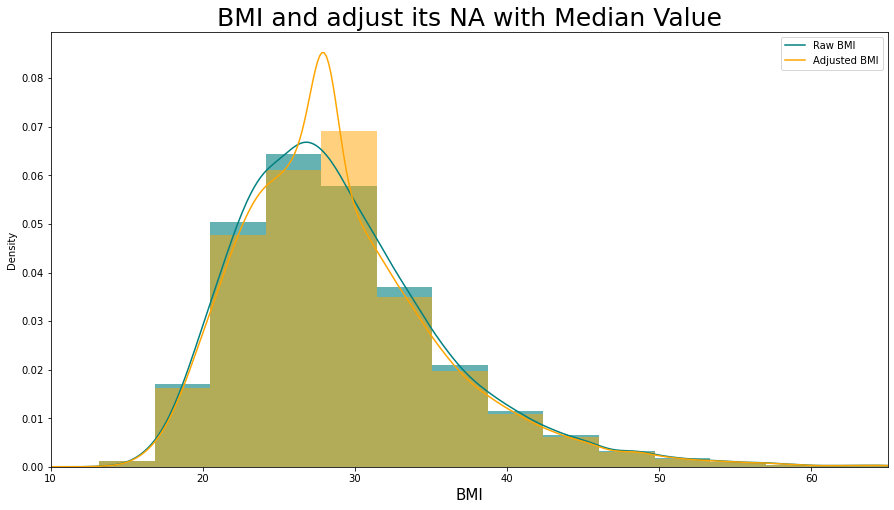

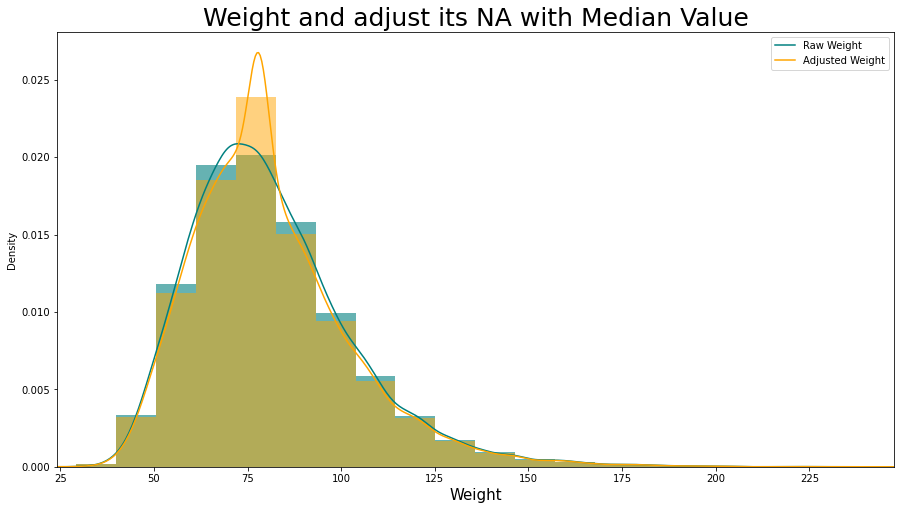

In [4]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression import linear_model as lm
from matplotlib.backends.backend_pdf import PdfPages

"""
Use linear regression to assess the relationships between several
variables and blood pressure in the NHANES data.
"""

years=['2009-2010', '2011-2012', '2013-2014', '2015-2016','2017-2018']
# years=['2017-2018']
pdf = PdfPages("data_distribution.pdf")
total=[]
for year in years:
    data=readData(year)
    ii = data.loc[:,VNH["Age"]] >= 18
    data = data.loc[ii,:]
    total.append(data)
#
#     # pdf = PdfPages("data_distribution_%s.pdf" % year)
#
    for item in VNH.values():
        fig=plt.figure(figsize=(15,8))
        ax = data[item].hist(bins=20, density=True, stacked=True, color='teal', alpha=0.6)
        data[item].plot(kind='density', color='teal')
        ax.legend([item])
        ax.set_xlabel(item, fontsize=15)
        naCount=data[item].isnull().sum()
        totalCount=data.shape[0]
        ax.set_title("%s %s Distribution. Non-NA/Total ratio: %d/%d" % (item,year, totalCount-naCount, totalCount), fontsize=25)
        plt.xlim(data[item].min(skipna=True)-5,data[item].max(skipna=True)+5)
        pdf.savefig()
        plt.close(fig)
    # pdf.close()

df1=pd.concat(total)
data=df1.copy()

# BMI's Mean
print('The mean of "BMI" is %.2f' %(df1[VNH['BMI']].mean(skipna=True)))
# BMI's Median
print('The median of "BMI" is %.2f' %(df1[VNH['BMI']].median(skipna=True)))

data[VNH['BMI']].fillna(df1[VNH['BMI']].median(skipna=True), inplace=True)
plt.figure(figsize=(15,8))
ax = df1[VNH['BMI']].hist(bins=20, density=True, stacked=True, color='teal', alpha=0.6)
df1[VNH['BMI']].plot(kind='density', color='teal')
ax = data[VNH['BMI']].hist(bins=20, density=True, stacked=True, color='orange', alpha=0.5)
data[VNH['BMI']].plot(kind='density', color='orange')
ax.legend(['Raw BMI', 'Adjusted BMI'])
ax.set_xlabel('BMI', fontsize=15)
ax.set_title("BMI and adjust its NA with Median Value", fontsize=25)
plt.xlim(10,65)
plt.savefig('pic/BMI_data_distribution.png')
pdf.savefig()


# Weight's Mean
print('The mean of "Weight" is %.2f' %(df1[VNH['Weight']].mean(skipna=True)))
# Weight's Median
print('The median of "Weight" is %.2f' %(df1[VNH['Weight']].median(skipna=True)))


plt.figure(figsize=(15,8))
data[VNH['Weight']].fillna(df1[VNH['Weight']].median(skipna=True), inplace=True)
ax1 = df1[VNH['Weight']].hist(bins=20, density=True, stacked=True, color='teal', alpha=0.6)
df1[VNH['Weight']].plot(kind='density', color='teal')
ax1 = data[VNH['Weight']].hist(bins=20, density=True, stacked=True, color='orange', alpha=0.5)
data[VNH['Weight']].plot(kind='density', color='orange')
ax1.legend(['Raw Weight', 'Adjusted Weight'])
ax1.set_xlabel('Weight', fontsize=15)
ax1.set_title("Weight and adjust its NA with Median Value", fontsize=25)
# pdf.savefig()
plt.xlim(data[VNH['Weight']].min(skipna=True)-5,data[VNH['Weight']].max(skipna=True)+5)
plt.savefig('pic/Weight_data_distribution.png')
pdf.savefig()
pdf.close()

In [5]:
def dataETL(year='2009-2010'):
    d=readData(year)
    print("Begin to Clean %s data." % year)
    ## Put a data set together for regression analysis
    print("Total Count of Data: %d" % d[VNH.values()].shape[0])
    ii = d.loc[:,VNH["Age"]] >= 18
    dSub = d.loc[ii,VNH.values()]
    print("Age > 18 Count of Data: %d" % dSub.shape[0])
    dSub[VNH['BMI']].fillna(d[VNH['BMI']].median(skipna=True), inplace=True)
    dSub[VNH['Weight']].fillna(d[VNH['Weight']].median(skipna=True), inplace=True)
    dSub[VNH['Smoking']].fillna(0, inplace=True)
    dSub[VNH['Alcohol']].fillna(0, inplace=True)

    return dSub


In [6]:
def dataConcat(start=2005, end=2018):
    year_codes = get_nhanes_year_code_dict()
    D=[]
    for year in year_codes.keys():
        if start <= int(year.split('-')[0]) and end >= int(year.split('-')[1]):
            df = dataETL(year)
            D.append(df)
    return pd.concat(D)

df=dataConcat()


Begin to Ingest 2005-2006 data.
Begin to Clean 2005-2006 data.
Total Count of Data: 10348
Age > 18 Count of Data: 5563
Begin to Ingest 2007-2008 data.
Begin to Clean 2007-2008 data.
Total Count of Data: 10149
Age > 18 Count of Data: 6228
Begin to Ingest 2009-2010 data.
Begin to Clean 2009-2010 data.
Total Count of Data: 10537
Age > 18 Count of Data: 6527
Begin to Ingest 2011-2012 data.
Begin to Clean 2011-2012 data.
Total Count of Data: 9756
Age > 18 Count of Data: 5864
Begin to Ingest 2013-2014 data.
Begin to Clean 2013-2014 data.
Total Count of Data: 10175
Age > 18 Count of Data: 6113
Begin to Ingest 2015-2016 data.
Begin to Clean 2015-2016 data.
Total Count of Data: 9971
Age > 18 Count of Data: 5992
Begin to Ingest 2017-2018 data.
Begin to Clean 2017-2018 data.
Total Count of Data: 9254
Age > 18 Count of Data: 5856


In [7]:
print("Total Population: %d" % df.shape[0])
print("Total Deceased Population: %d" % df[df[VNH['Die']]==1].shape[0])
print("Total Cancer Deceased Population: %d" % df[df['dieOfCancer']==1].shape[0])
print(df.isnull().sum())
df.head()

Total Population: 42143
Total Deceased Population: 4530
Total Cancer Deceased Population: 1032
DEMO:RIAGENDR        0
DEMO:RIDAGEYR        0
BMX:BMXWT            0
BMX:BMXBMI           0
smokingYears         0
alcoholPerYear       0
income               0
HDL:LBDHDD        4191
MORTSTAT           121
dieOfCancer          0
dtype: int64


,DEMO:RIAGENDR,DEMO:RIDAGEYR,BMX:BMXWT,BMX:BMXBMI,smokingYears,alcoholPerYear,income,HDL:LBDHDD,MORTSTAT,dieOfCancer
SEQN,,,,,,,,,,
31130.0,2.0,85.0,63.2,24.31,0.0,0.0,17500.0,NaN,1.0,2
31131.0,2.0,44.0,75.2,30.90,0.0,0.0,0.0,39.0,0.0,0
31132.0,1.0,70.0,69.5,24.74,0.0,208.0,0.0,59.0,0.0,0
31134.0,1.0,73.0,101.9,30.63,0.0,104.0,25000.0,49.0,0.0,0
31136.0,2.0,41.0,63.2,24.31,0.0,0.0,40000.0,NaN,0.0,0


In [8]:
print("Male Record Counts: %d" % df[VNH['Gender']].value_counts().to_dict()[1])
print("Female Record Counts: %d" % df[VNH['Gender']].value_counts().to_dict()[2])
print("Total Cancer Deceased Population: %d" % df[df['dieOfCancer']==1].shape[0])
VN = list(VNH.keys())[1:-2]

ii = df[VNH['Gender']] == 1
jj = df[VNH['Gender']] == 2
print("Total Median")
print('=====================================')
print(df[[VNH[x] for x in VN]].median(skipna=True))
print('Male Median')
print('=====================================')
print(df.loc[ii, [VNH[x] for x in VN]].median(skipna=True))
print("Female Median")
print('=====================================')
print(df.loc[jj, [VNH[x] for x in VN]].median(skipna=True))



Male Record Counts: 20458
Female Record Counts: 21685
Total Cancer Deceased Population: 1032
Total Median
DEMO:RIDAGEYR        47.00
BMX:BMXWT            76.70
BMX:BMXBMI           27.43
smokingYears          0.00
alcoholPerYear        2.00
income            30000.00
HDL:LBDHDD           51.00
dtype: float64
Male Median
DEMO:RIDAGEYR        48.00
BMX:BMXWT            82.10
BMX:BMXBMI           27.29
smokingYears          3.00
alcoholPerYear        6.00
income            30000.00
HDL:LBDHDD           46.00
dtype: float64
Female Median
DEMO:RIDAGEYR        47.00
BMX:BMXWT            70.80
BMX:BMXBMI           27.67
smokingYears          0.00
alcoholPerYear        1.00
income            30000.00
HDL:LBDHDD           56.00
dtype: float64


['Age', 'Weight', 'BMI', 'Smoking', 'Alcohol', 'Income', 'HDLC']


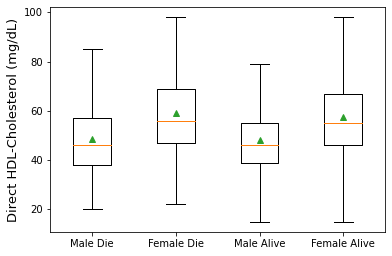

In [9]:
def draw_DF_Distrib(df_all:pd.DataFrame, label='raw'):
    pdf = PdfPages("nhanes_var_cancerDie_plots_%s.pdf" % label)
    ii = df_all.loc[:,VNH["DieOfCancer"]] !=2
    df = df_all.copy().loc[ii,:]
    ## Make box plots between categorical predictors and the outcome
    VN = list(VNH.keys())[1:-2]
    print(VN)

    Codes = {'dieOfCancer':{1:'Deceased',0:"Alive"},
             "DieWithGender":{0:'Male Die',
                              1:'Female Die',
                              2:'Male Alive',
                              3:'Female Alive'}}
    for vname in VN:
        df_Sub = df.loc[:,[VNH[x] for x in [vname, "Gender","DieOfCancer"]]]
        df_Sub.dropna(inplace=True)
        X = df_Sub.loc[:,'dieOfCancer']
        S = list(set(X))
        Y = df_Sub.loc[:,VNH[vname]]
        B = [Y[X==s] for s in S]
        plt.clf()
        plt.gcf().subplots_adjust(bottom=0.1)
        plt.boxplot(B,sym='',showmeans=True,vert=True, showfliers=True, notch=True)
        codes = Codes[VNH['DieOfCancer']]
        if vname == "Smoking":
            plt.ylabel("Years of Smoking", size=17)
        elif vname == "Alcohol":
            plt.ylabel("Drink Days Per Year", size=17)
        elif vname == 'HDLC':
            plt.ylabel("Direct HDL-Cholesterol (mg/dL)", size=13)
        else:
            plt.ylabel(vname, size=17)
        plt.gca().set_xticklabels([codes[s] for s in S])
        plt.savefig("pic/distribution_total_%s.png" % vname)
        pdf.savefig(bbox_inches="tight")

        X = df_Sub.loc[:,[VNH[x] for x in ["Gender","DieOfCancer"]]]
        X['value']=X.apply(lambda x: (0 if x[VNH['Gender']]==1 else 1) if x[VNH['DieOfCancer']] == 1 else (2 if x[VNH['Gender']]==1 else 3) ,axis=1)
        S = list(set(X['value']))
        Y = df_Sub.loc[:,VNH[vname]]
        B = [Y[X['value']==s] for s in S]
        plt.clf()
        plt.boxplot(B,0,'',showmeans=True,vert=True)
        codes = Codes['DieWithGender']
        if vname == "Smoking":
            plt.ylabel("Years of Smoking", size=17)
        elif vname == "Alcohol":
            plt.ylabel("Drink Days Per Year", size=17)
        elif vname == 'HDLC':
            plt.ylabel("Direct HDL-Cholesterol (mg/dL)", size=13)
        else:
            plt.ylabel(vname, size=17)
        plt.gca().set_xticklabels([codes[s] for s in S])
        plt.savefig("pic/distribution_gender_%s.png" % vname)
        pdf.savefig(bbox_inches="tight")


    pdf.close()

draw_DF_Distrib(df)

### Try to remove abnormal value exceed 75% or less than 25% (Work in Progress)

In [10]:
# Can skip this block

VN = list(VNH.keys())[1:-2]
new_df = df.copy()
for vname in VN:
    itemAlive = new_df.loc[new_df['dieOfCancer']==1,VNH[vname]]
    new_df = new_df.drop(new_df[(new_df[VNH[vname]] > itemAlive.quantile(0.75)) | (new_df[VNH[vname]] < itemAlive.quantile(0.25))].index)
    itemDie = new_df.loc[new_df['dieOfCancer']==0,VNH[vname]]
    new_df = new_df.drop(new_df[(new_df[VNH[vname]] > itemDie.quantile(0.75)) | (new_df[VNH[vname]] < itemDie.quantile(0.25))].index)

# draw_DF_Distrib(new_df, 'remove')


### Split Data into Train and Test subset with ratio as 3:1 (25% test data)


In [11]:
from sklearn.model_selection import train_test_split

def data_split(raw_df, columnList=list(VNH.keys())[1:-2], do_dropna=True, ratio=0.25):
    # Use following Character to predict
    # VN =[VNH[x] for x in ['Age','Smoking','HDLC',]]
    VN =[VNH[x] for x in columnList]
    VNA = VN + [VNH['DieOfCancer'],]
    ii = raw_df.loc[:,VNH["DieOfCancer"]] != 2
    X_Y=raw_df.copy().loc[ii,VNA]

    if do_dropna:
        X_Y.dropna(inplace=True)

    # concat die and alive to a new dataframe
    columnNum=X_Y.shape[1]
    # pick last column 'dieOfCancer' as Y
    y = X_Y.iloc[:,columnNum-1]
    # pick rest columns as X (except 'dieOfCancer')
    X = X_Y.iloc[:,:columnNum-1]
    totalCount=X_Y.shape[0]
    cancerDieCount=X_Y[X_Y['dieOfCancer']==1].shape[0]
    aliveCount=X_Y[X_Y['dieOfCancer']==0].shape[0]
    print("Total Population: %d" % totalCount)
    print("Total Cancer Deceased Population: %d (%2.4f in total)"  % (cancerDieCount, cancerDieCount/totalCount))
    print("Total Alive Population: %d" % aliveCount)



    # split total DF into train set (75%) and test set (25%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=2)
    totalTrainCount=X_train.shape[0]
    totalTestCount=X_test.shape[0]
    cancerTrainCount=y_train[y_train==1].shape[0]
    cancerTestCount=y_test[y_test==1].shape[0]

    print("Train Set cancer deceased population:  %d (%2.4f in total)" % (cancerTrainCount, cancerTrainCount/totalTrainCount))
    print("Test Set cancer deceased population:  %d (%2.4f in total)" % (cancerTestCount, cancerTestCount/totalTestCount))
    dataDic={
        "xTrain": X_train,
        "xTest": X_test,
        "yTrain": y_train,
        "yTest": y_test,
        "X_Y": X_Y
    }
    return dataDic

dataDicAll = data_split(raw_df=df,)



Total Population: 34971
Total Cancer Deceased Population: 860 (0.0246 in total)
Total Alive Population: 34111
Train Set cancer deceased population:  644 (0.0246 in total)
Test Set cancer deceased population:  216 (0.0247 in total)


### Logistic Regression Algorithm

In [115]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import *

def logistic_predict(dataDic, is_balance=False, label=""):

    # Do logistic Regression
    X_train = dataDic['xTrain']
    X_test = dataDic['xTest']
    y_train = dataDic['yTrain']
    y_test = dataDic['yTest']
    logreg = LogisticRegression()
    if is_balance:
        logreg = LogisticRegression(class_weight = 'balanced')
    logreg.fit(X_train, y_train.values.reshape(-1))
    y_pred = logreg.predict(X_test)
    print('Accuracy Based on Test Data: {:.2f}'.format(logreg.score(X_test, y_test)))

    print('Train/Test split results:')
    print("Accuracy: %2.3f" % accuracy_score(y_test, y_pred))

    if not os.path.exists('pic/LR'):
        os.makedirs('pic/LR')

    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.3f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=15)
    plt.ylabel('True Positive Rate',fontsize=15)
    plt.title('Logistic Regression ROC',fontsize=20)
    plt.legend(loc="lower right")
    plt.savefig("pic/LR/ROC_%s.png" % label )
    plt.show()

    fig=plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.PuBuGn)
    plt.title("%s Confusion Matrix" % label, fontsize=20)
    plt.xlabel('Predicted Value',fontsize=15)
    plt.ylabel("True Value", fontsize=15)
    plt.xticks([0,1], ['Alive', 'Deceased'])
    plt.yticks([0,1], ['Alive', 'Deceased'], rotation=90)
    plt.savefig("pic/LR/ConfM_%s.png" % label )
    plt.show()

    outputDF=pd.DataFrame(X_test, index=X_test.index, columns=VN)
    outputDF[VNH['DieOfCancer']]=pd.DataFrame(y_test, index=X_test.index, columns=[VNH['DieOfCancer']])
    outputDF['predDieOfCancer']=pd.DataFrame(y_pred, index=X_test.index, columns=[VNH['DieOfCancer']])

    return outputDF

# Draw histgram between test result and predict result
def draw_Test_Pred(outputDF, label="", bins=5):
    testDF=outputDF.loc[:, 'dieOfCancer']
    predDF=outputDF.loc[:, 'predDieOfCancer']

    Codes = {0:"Alive", 1:'Deceased',}
    plt.figure(figsize=(15,8))
    ax = testDF.hist(bins=bins, density=False, stacked=True, color='teal', alpha=0.5)
    ax = predDF.hist(bins=bins, density=False, stacked=True, color='orange', alpha=0.5)
    ax.legend(['Real DieOfCancer', 'Pred DieOfCancer'],fontsize=15)
    ax.set_xlabel('DieOfCancer', fontsize=20)
    ax.set_title("Die of Cancer/Alive Prediction Result", fontsize=25)
    ax.set_xticks([-0.5,0,1,1.5])
    ax.set_xticklabels([' ']+list(Codes.values())+[' '],fontsize=15)
    ratio={}
    for bar in ax.patches:
        x=bar.get_x() + bar.get_width() / 2
        y=bar.get_height()
        if y>0 and not ratio.keys().__contains__(x):
            ratio[x]=[]
            ratio[x].append(y)
        elif y > 0:
            ratio[x].append(y)
            if ratio[x][0]>ratio[x][1]:
                ratio[x].append(ratio[x][0])
            else:
                ratio[x].append(ratio[x][1])
    if label.find('RF') != -1:
        plt.savefig('pic/RF/RawVsPredict_%s.png' % label)
    elif label.find('LR') != -1:
        plt.savefig('pic/LR/RawVsPredict_%s.png' % label)
    for key in ratio.keys():
        ax.annotate(format(ratio[key][0]/ratio[key][1], '.2f'),
                    (key,ratio[key][2]), ha='center', va='center',
                    size=15, xytext=(0, 8),
                    textcoords='offset points')

    if label.find('RF') != -1:
        plt.savefig('pic/RF/RawVsPredict_%s.png' % label)
    elif label.find('LR') != -1:
        plt.savefig('pic/LR/RawVsPredict_%s.png' % label)
    plt.show()


### To do Logistic Prediction on All Data

Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976


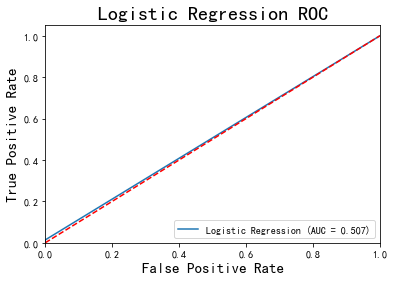

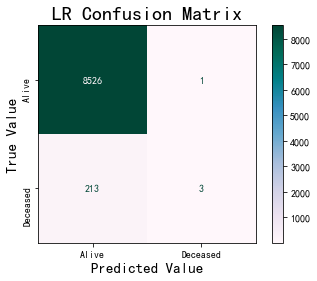

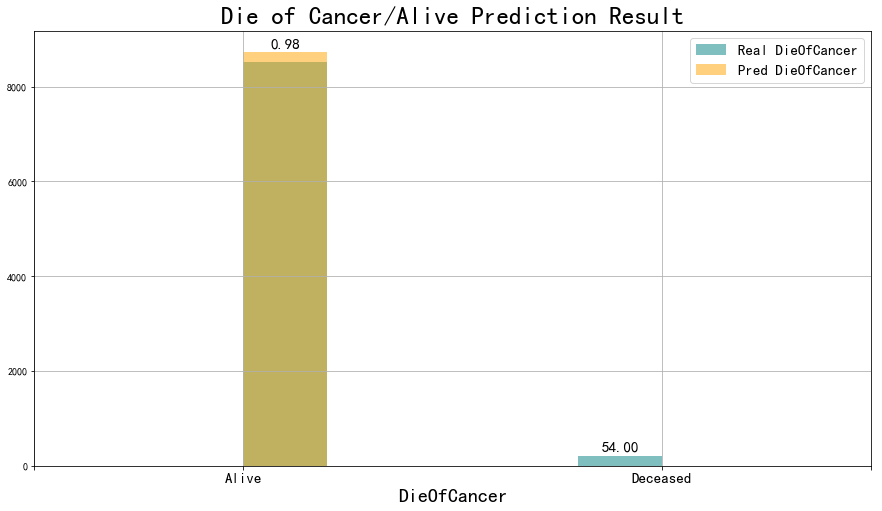

Accuracy Based on Test Data: 0.73
Train/Test split results:
Accuracy: 0.733


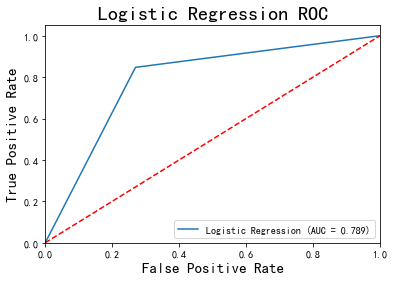

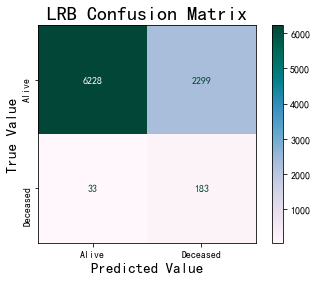

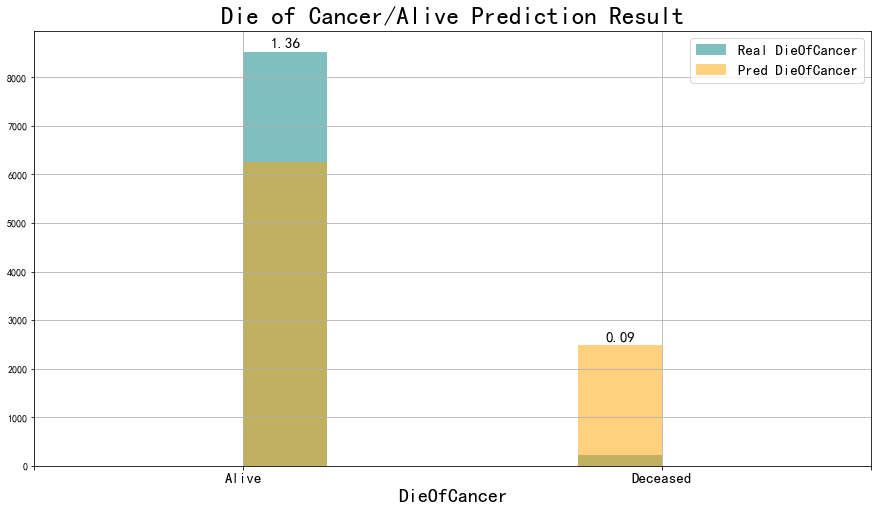

In [116]:
outputDFLR = logistic_predict(dataDicAll, label="LR")

try:
    draw_Test_Pred(outputDFLR, "LR")
except IndexError:
    draw_Test_Pred(outputDFLR, "LR", 10)
    print("An exception occur")

outputDFLRBal = logistic_predict(dataDicAll, is_balance=True, label="LRB")
draw_Test_Pred(outputDFLRBal, "LRB")

### Random Forest Classifier

In [87]:
from sklearn.ensemble import *
from imblearn.ensemble import *


def randomForest_decision(dataDic, regressor, label=""):

    # regressor = RandomForestClassifier(n_estimators=80, oob_score=True, bootstrap = True,
    #                                    max_features = 'sqrt', class_weight='balanced')

    # regressor = RandomForestClassifier(n_estimators=20)#, oob_score=True, bootstrap = True,
    #                                    max_features='log2', class_weight='balanced')
    # regressor = BalancedRandomForestClassifier(n_estimators=20, oob_score=True, bootstrap = True,
    #                                                max_features='log2' ,class_weight='balanced')
    # regressor = BalancedBaggingClassifier(n_estimators=80)
    X_train = dataDic['xTrain']
    X_test = dataDic['xTest']
    y_train = dataDic['yTrain']
    y_test = dataDic['yTest']

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mcc=matthews_corrcoef(y_test, y_pred)

    print('Accuracy Based on Test Data: {:.2f}'.format(regressor.score(X_test, y_test)))

    print('Train/Test split results:')
    print("Accuracy: %2.3f" % accuracy_score(y_test, y_pred))
    print("Matthews Corr: %2.3f" % mcc)
    # print("accuracy:%f"%regressor.oob_score_)

    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    if not os.path.exists('pic/RF'):
        os.makedirs('pic/RF')

    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest Classifier (AUC = %0.3f/MCC = %0.3f)' % (logit_roc_auc, mcc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=15)
    plt.ylabel('True Positive Rate',fontsize=15)
    plt.title('RandomForest Classifier ROC',fontsize=20)
    plt.legend(loc="lower right")
    plt.savefig("pic/RF/ROC_%s.png" % label )
    plt.show()

    fig=plot_confusion_matrix(regressor, X_test, y_test, cmap=plt.cm.PuBuGn)
    plt.title("%s Confusion Matrix" % label, fontsize=20)
    plt.xlabel('Predicted Value',fontsize=15)
    plt.ylabel("True Value", fontsize=15)
    plt.xticks([0,1], ['Alive', 'Deceased'])
    plt.yticks([0,1], ['Alive', 'Deceased'], rotation=90)
    plt.savefig("pic/RF/ConfM_%s.png" % label )
    plt.show()


    outputDF=pd.DataFrame(X_test, index=X_test.index, columns=VN)
    outputDF[VNH['DieOfCancer']]=pd.DataFrame(y_test, index=X_test.index, columns=[VNH['DieOfCancer']])
    outputDF['predDieOfCancer']=pd.DataFrame(y_pred, index=X_test.index, columns=[VNH['DieOfCancer']])

    return outputDF



### Random Forest on data regression

Ratio between Alive and Cancer in train is 40
Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.975
Matthews Corr: 0.110


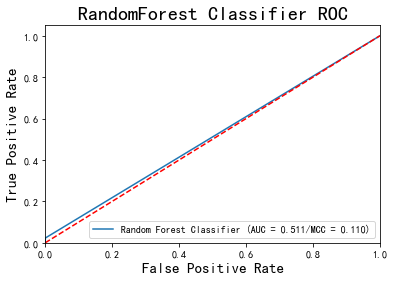

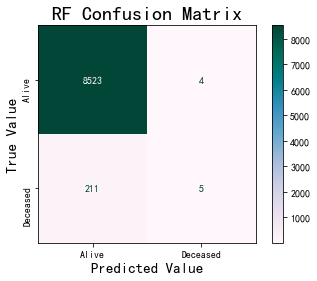

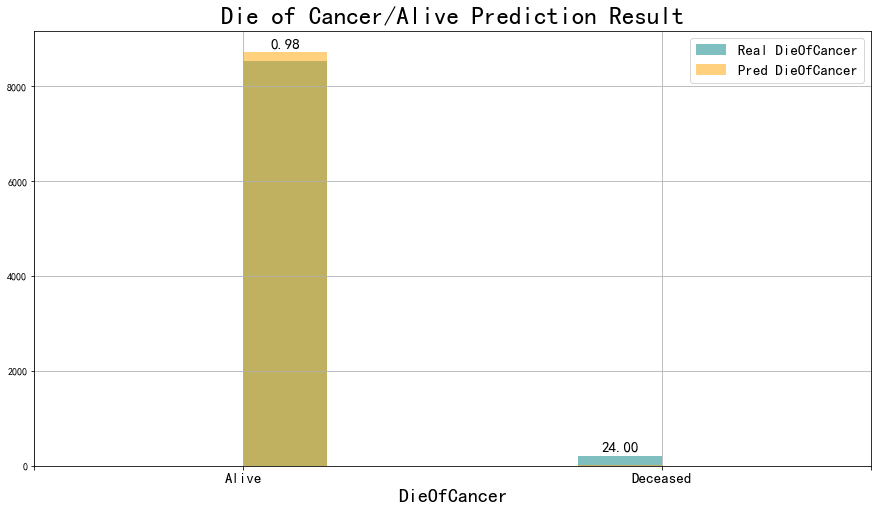

Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.975
Matthews Corr: 0.114


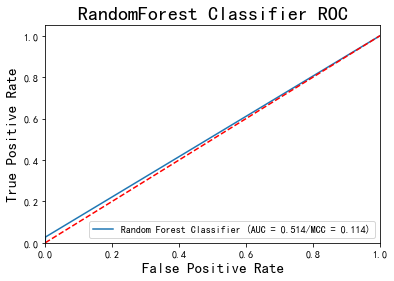

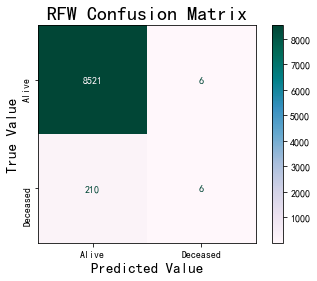

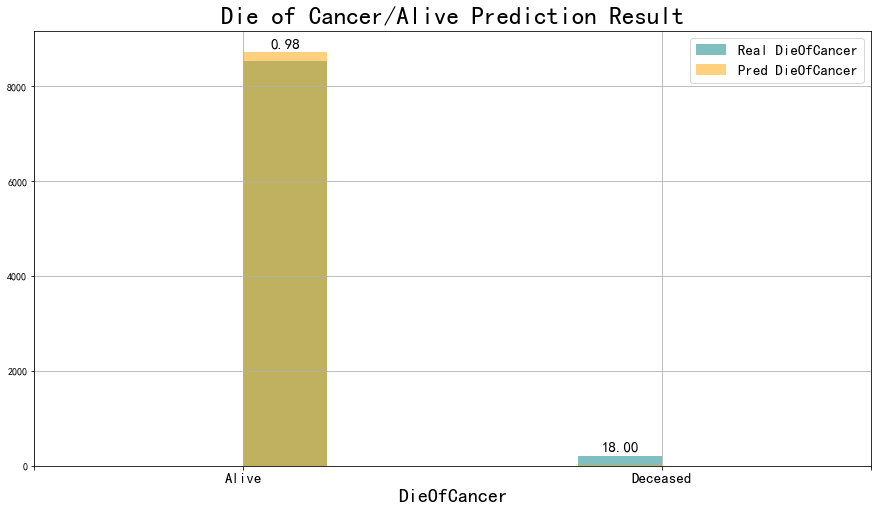

Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.975
Matthews Corr: 0.067


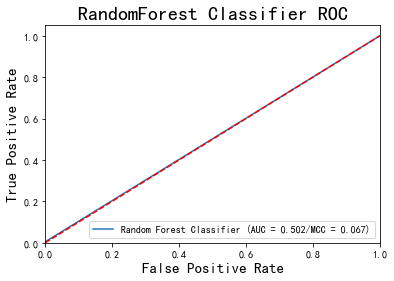

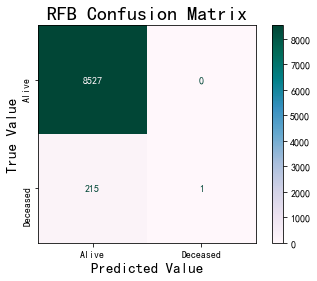

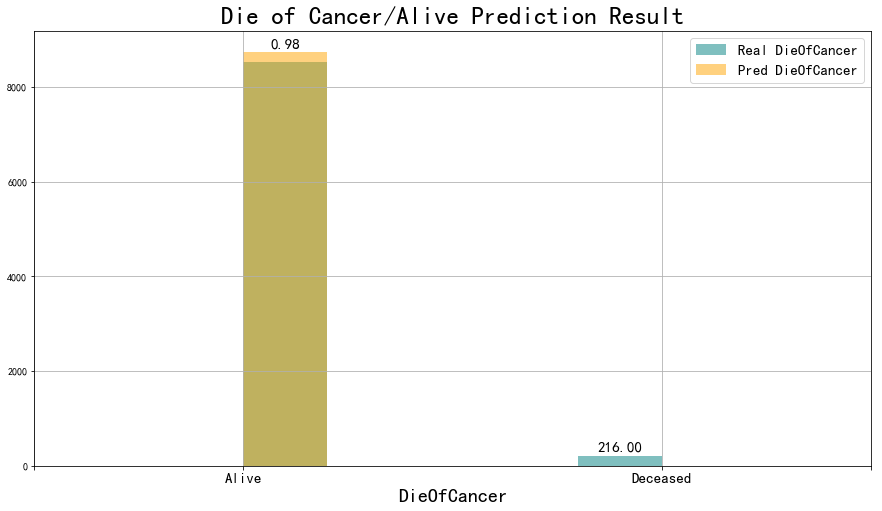

Accuracy Based on Test Data: 0.71
Train/Test split results:
Accuracy: 0.714
Matthews Corr: 0.203


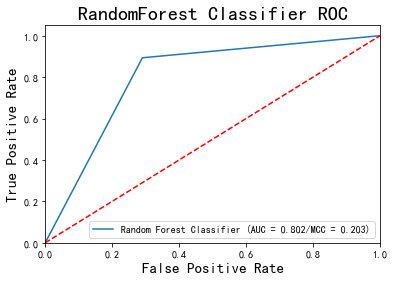

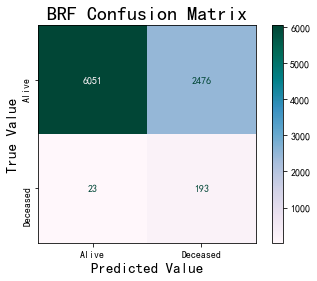

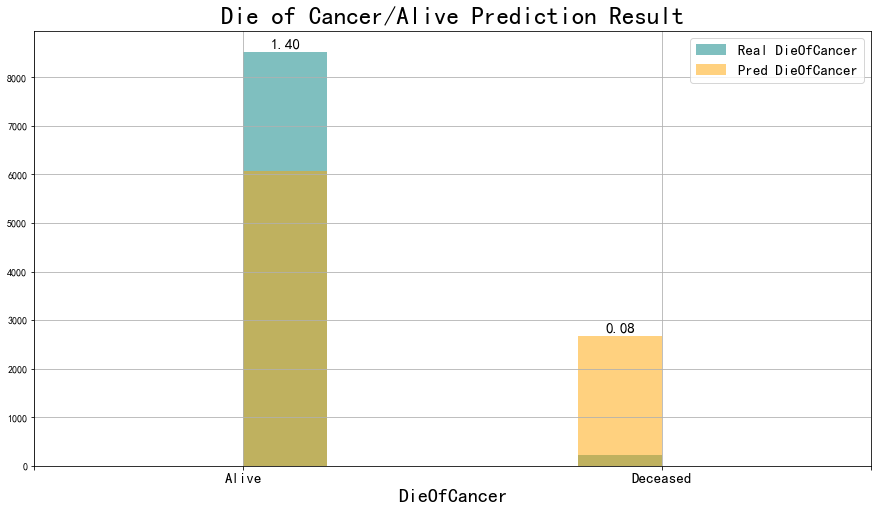

In [143]:
def cal_aliveCacer_ratio(dataDic):
    alive2cancer=round(dataDic['yTrain'][dataDic['yTrain']==0].shape[0]/dataDic['yTrain'][dataDic['yTrain']==1].shape[0])
    return alive2cancer

# ratio between alive records and cancer records
alive2cancer=cal_aliveCacer_ratio(dataDicAll)
print("Ratio between Alive and Cancer in train is %d" % alive2cancer)

# random forest original
regressor = RandomForestClassifier()
outputDFRF = randomForest_decision(dataDicAll, regressor= regressor, label="RF", )
draw_Test_Pred(outputDFRF, "RF")

# random forest with class_weight={0:40, 1:1}
regressor = RandomForestClassifier(class_weight={0:alive2cancer,1:1})
outputDFRF = randomForest_decision(dataDicAll, regressor= regressor, label="RFW", )
draw_Test_Pred(outputDFRF, "RFW")

# random forest with class_weight=balanced
regressor = RandomForestClassifier(class_weight='balanced')
outputDFRF = randomForest_decision(dataDicAll, regressor= regressor, label="RFB", )
draw_Test_Pred(outputDFRF, "RFB")

# balanced random forest with class_weight={0:40, 1:1}
regressor = BalancedRandomForestClassifier(class_weight={0:alive2cancer,1:1})
outputDFRFBal = randomForest_decision(dataDicAll, regressor= regressor, label="BRF")
draw_Test_Pred(outputDFRFBal, "BRF")


### Try to use under sample

Records of Alive and Cancer in train is (25584, 644)
Records of Alive and Cancer in under sample is (644, 644)
Accuracy Based on Test Data: 0.72
Train/Test split results:
Accuracy: 0.720
Matthews Corr: 0.210


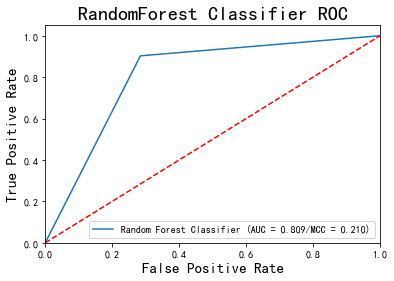

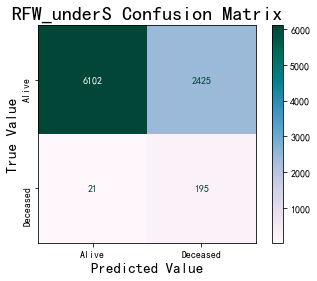

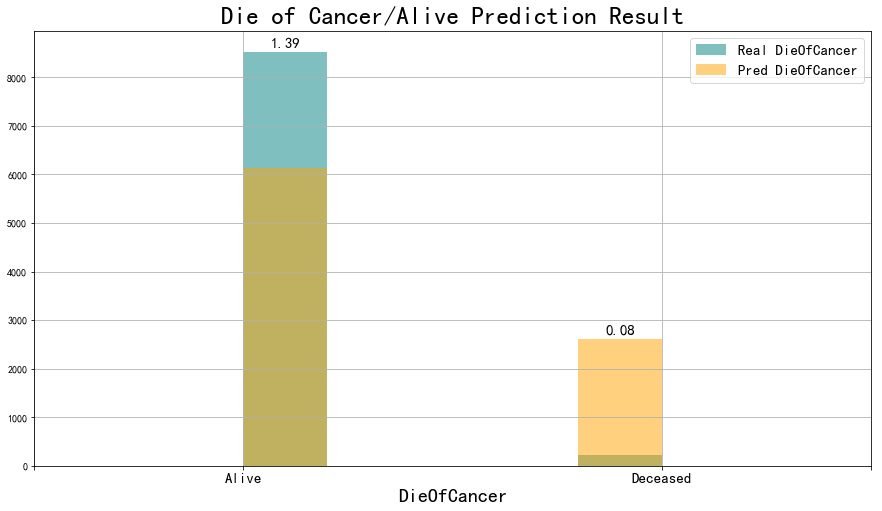

In [123]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(dataDicAll['xTrain'], dataDicAll['yTrain'])
print("Records of Alive and Cancer in train is (%d, %d)" % (dataDicAll['yTrain'][dataDicAll['yTrain']==0].shape[0],
                                                            dataDicAll['yTrain'][dataDicAll['yTrain']==1].shape[0]))
print("Records of Alive and Cancer in under sample is (%d, %d)" %
      (y_resampled[y_resampled==0].shape[0], y_resampled[y_resampled==1].shape[0]))

dataDicRes=dataDicAll.copy()
dataDicRes['xTrain']=X_resampled
dataDicRes['yTrain']=y_resampled

regressor = RandomForestClassifier(class_weight={0:alive2cancer,1:1},)
outputDFRFBal = randomForest_decision(dataDicRes, regressor= regressor, label="RFW_underS")
draw_Test_Pred(outputDFRFBal, "RFW_underS")


### Random Forest Regression n_estimator estimation


In [133]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

scores=[]
param_test1 = {
        'n_estimators': range(10, 71, 5)
}
model = GridSearchCV(estimator=RandomForestClassifier(class_weight={0:alive2cancer,1:1}),
                     param_grid=param_test1, cv=5, )
model.fit(dataDicAll['xTrain'], dataDicAll['yTrain'])
y_pred=model.predict(dataDicAll['xTest'])

# for val in range(10,71,5):
#     clf = BalancedRandomForestClassifier(n_estimators=val,class_weight={0:alive2cancer,1:1})
#     validated=cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
#     scores.append(validated)

best_estimator=model.best_params_['n_estimators']
print('Best Score: %2.4f' % model.best_score_)
print('Best Estimater: %s' % best_estimator)


# sns.boxplot(data=scores)
# plt.xlabel("Number of Trees")
# plt.ylabel("Classification Scores")
# plt.xticks(ticks=range(0,13),labels=range(10,71,5))
# plt.text(8, min(scores[0]),'Best Estimater: %s' % best_estimator, fontsize=12)
# plt.savefig('pic/RF_Score_on_TreeNumber.png')
# plt.show()


Best Score: 0.9761
Best Estimater: 45


Accuracy Based on Test Data: 0.97
Train/Test split results:
Accuracy: 0.975
Matthews Corr: 0.097


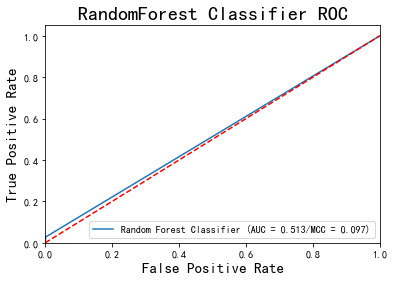

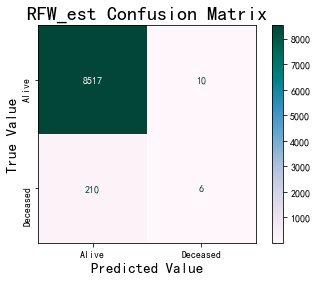

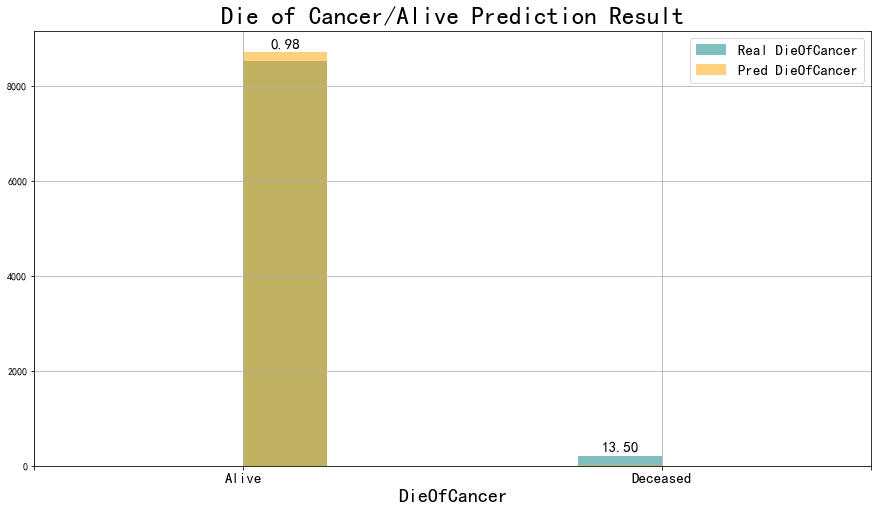

In [134]:
# Thus we set previous calculated best_estimator amd do RF again

regressor = RandomForestClassifier(n_estimators=best_estimator,class_weight={0:alive2cancer,1:1})
outputDFRFBal = randomForest_decision(dataDicAll, regressor= regressor, label="RFW_est")
draw_Test_Pred(outputDFRFBal, "RFW_est")


### Random Forest Regression n_estimator estimation

In [135]:
param_test2 = {
    'max_features': range(2, 20, 2),
}
model = GridSearchCV(estimator=RandomForestClassifier(n_estimators=best_estimator,class_weight={0:alive2cancer,1:1}),
                     param_grid=param_test2, cv=5,)
model.fit(dataDicAll['xTrain'], dataDicAll['yTrain'])
y_pred=model.predict(dataDicAll['xTest'])

best_max_features = model.best_params_['max_features']
print('Best Score: %2.4f' % model.best_score_)
print('Best Parameters: %s' % model.best_params_)


Best Score: 0.9759
Best Parameters: {'max_features': 4}


Accuracy Based on Test Data: 0.97
Train/Test split results:
Accuracy: 0.974
Matthews Corr: 0.104


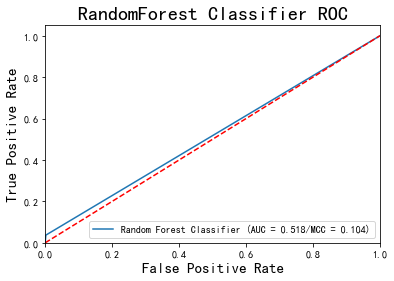

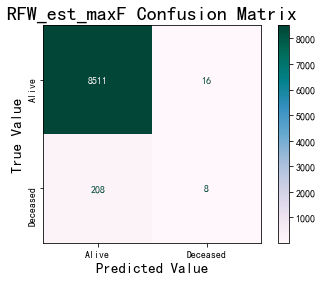

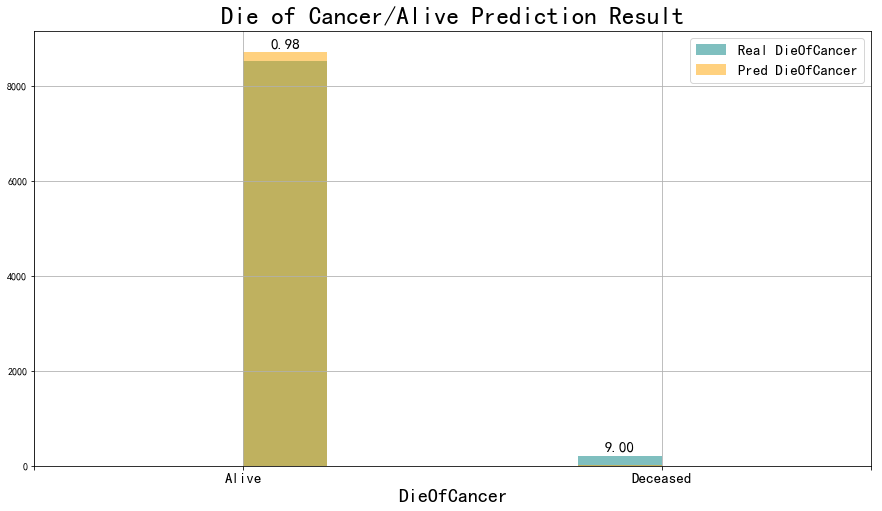

In [142]:
regressor = RandomForestClassifier(n_estimators=best_estimator, max_features=best_max_features,class_weight={0:alive2cancer,1:1} )
outputDFRFBal = randomForest_decision(dataDicAll, regressor= regressor, label="RFW_est_maxF")
draw_Test_Pred(outputDFRFBal, "RFW_est_maxF")



### Factor importance in Random Forest

Importances： [4.78242135e-02 2.12063793e-02 5.32389022e-02 1.33252705e-02
 1.62222987e-03 1.29173508e-05 5.53782752e-02]
 1) HDLC                           0.055378
 2) BMI                            0.053239
 3) Age                            0.047824
 4) Weight                         0.021206
 5) Smoking                        0.013325
 6) Alcohol                        0.001622
 7) Income                         0.000013
['HDLC', 'BMI', 'Age', 'Weight', 'Smoking', 'Alcohol', 'Income']
7
Index(['DEMO:RIDAGEYR', 'BMX:BMXWT', 'BMX:BMXBMI', 'smokingYears',
       'alcoholPerYear', 'income', 'HDL:LBDHDD'],
      dtype='object')
[0 1 2 3 4 5 6]
[False False False False False False False]


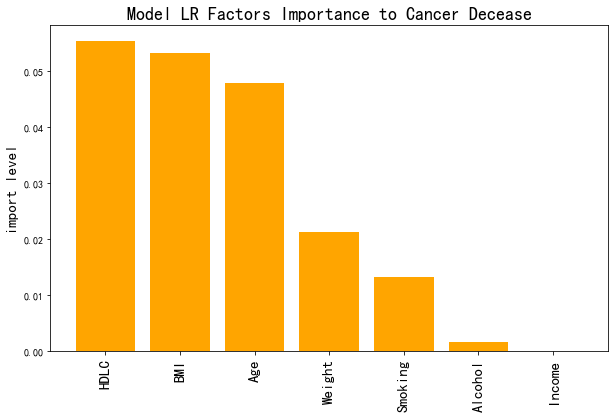

Importances： [6.35881667e-02 1.83365055e-02 1.17022925e-02 2.22309340e-02
 2.75113364e-04 1.06135212e-05 3.17940209e-02]
 1) Age                            0.063588
 2) HDLC                           0.031794
 3) Smoking                        0.022231
 4) Weight                         0.018337
 5) BMI                            0.011702
 6) Alcohol                        0.000275
 7) Income                         0.000011
['Age', 'HDLC', 'Smoking', 'Weight', 'BMI', 'Alcohol', 'Income']
7
Index(['DEMO:RIDAGEYR', 'BMX:BMXWT', 'BMX:BMXBMI', 'smokingYears',
       'alcoholPerYear', 'income', 'HDL:LBDHDD'],
      dtype='object')
[0 1 2 3 4 5 6]
[False False False False False False False]


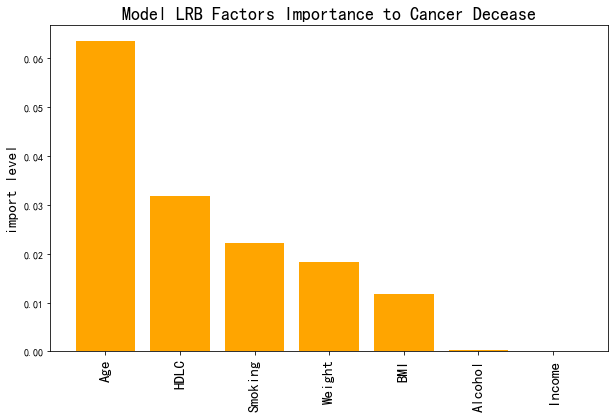

Importances： [0.10382422 0.2362443  0.23384171 0.10245615 0.07273386 0.0983015
 0.15259826]
 1) Weight                         0.236244
 2) BMI                            0.233842
 3) HDLC                           0.152598
 4) Age                            0.103824
 5) Smoking                        0.102456
 6) Income                         0.098301
 7) Alcohol                        0.072734
['Weight', 'BMI', 'HDLC', 'Age', 'Smoking', 'Income', 'Alcohol']
7
Index(['DEMO:RIDAGEYR', 'BMX:BMXWT', 'BMX:BMXBMI', 'smokingYears',
       'alcoholPerYear', 'income', 'HDL:LBDHDD'],
      dtype='object')
[0 1 2 3 4 5 6]
[ True  True  True  True False False  True]


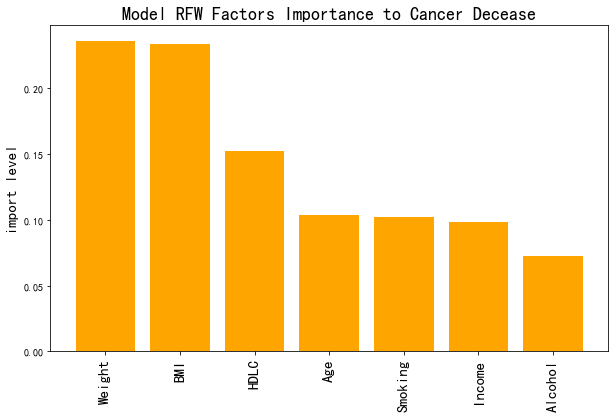

Importances： [0.17528477 0.16749397 0.17690935 0.13325608 0.07767174 0.09424796
 0.17513613]
 1) BMI                            0.176909
 2) Age                            0.175285
 3) HDLC                           0.175136
 4) Weight                         0.167494
 5) Smoking                        0.133256
 6) Income                         0.094248
 7) Alcohol                        0.077672
['BMI', 'Age', 'HDLC', 'Weight', 'Smoking', 'Income', 'Alcohol']
7
Index(['DEMO:RIDAGEYR', 'BMX:BMXWT', 'BMX:BMXBMI', 'smokingYears',
       'alcoholPerYear', 'income', 'HDL:LBDHDD'],
      dtype='object')
[0 1 2 3 4 5 6]
[ True  True  True  True False False  True]


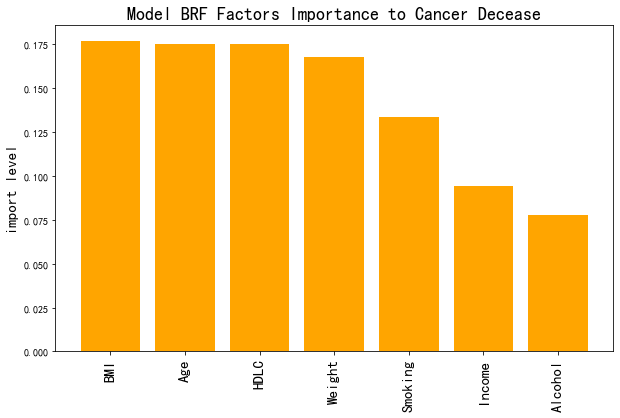

In [138]:
VN_Name = list(VNH.keys())[1:-2]
x_train_total = dataDicAll['xTrain']
x_test_total = dataDicAll['xTest']
y_train_total = dataDicAll['yTrain']
y_test_total = dataDicAll['yTest']
X_Y_total = dataDicAll['X_Y']


feat_labels = X_Y_total.columns[:X_Y_total.shape[1]-1]
# n_estimators：tree number
# forest = BalancedRandomForestClassifier(n_estimators=best_estimator,max_features=best_max_features, class_weight={0:alive2cancer,1:1})
forest = RandomForestClassifier(n_estimators=best_estimator, max_features=best_max_features,class_weight={0:alive2cancer,1:1} )
bforest = BalancedRandomForestClassifier(class_weight={0:alive2cancer,1:1} )
lr = LogisticRegression()
lrb = LogisticRegression(class_weight='balanced' )
forest.fit(x_train_total, y_train_total)
bforest.fit(x_train_total, y_train_total)
lr.fit(x_train_total, y_train_total)
lrb.fit(x_train_total, y_train_total)
featureColumns = x_train_total.columns

def draw_importance_pic(importances_raw, featureColumns, label):
    # feature_importances
    importances=importances_raw.copy()
    for i in range(importances_raw.shape[0]):
        importances[i]=np.abs(importances_raw[i])
    print("Importances：", importances)
    indices = np.argsort(importances)[::-1]
    x_columns_indices = []
    for f in range(x_train_total.shape[1]):
        print("%2d) %-*s %f" % (f + 1, 30, VN_Name[indices[f]], importances[indices[f]]))
        x_columns_indices.append(VN_Name[indices[f]])

    print(x_columns_indices)
    print(featureColumns.shape[0])
    print(featureColumns)
    print(np.arange(featureColumns.shape[0]))


    # select character
    threshold = 0.1
    print(importances > threshold)
    x_selected = x_train_total.iloc[:, importances > threshold]


    plt.figure(figsize=(10, 6))
    plt.title("Model %s Factors Importance to Cancer Decease" % label, fontsize=18)
    plt.ylabel("import level", fontsize=15, rotation=90)
    plt.rcParams['font.sans-serif'] = ["SimHei"]
    plt.rcParams['axes.unicode_minus'] = False
    for i in range(featureColumns.shape[0]):
        plt.bar(i, importances[indices[i]], color='orange', align='center')
        plt.xticks(np.arange(featureColumns.shape[0]), x_columns_indices, rotation=90, fontsize=15)
    if label.find('RF') != -1:
        plt.savefig("pic/RF/factor_importance_%s.png" % label)
    elif label.find('LR') != -1:
        plt.savefig("pic/LR/factor_importance_%s.png" % label)
    plt.show()

draw_importance_pic(lr.coef_[0], featureColumns, 'LR')
draw_importance_pic(lrb.coef_[0], featureColumns, 'LRB')
draw_importance_pic(forest.feature_importances_, featureColumns, 'RFW')
draw_importance_pic(bforest.feature_importances_, featureColumns, 'BRF')

### Use sub columns of full dataset to run regression

Total Population: 38645
Total Cancer Deceased Population: 1032 (0.0267 in total)
Total Alive Population: 37613
Train Set cancer deceased population:  786 (0.0271 in total)
Test Set cancer deceased population:  246 (0.0255 in total)
Accuracy Based on Test Data: 0.97
Train/Test split results:
Accuracy: 0.971
Matthews Corr: 0.118


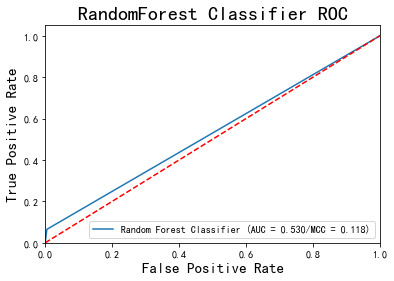

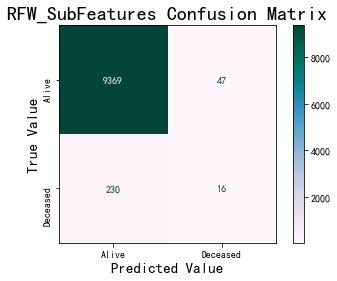

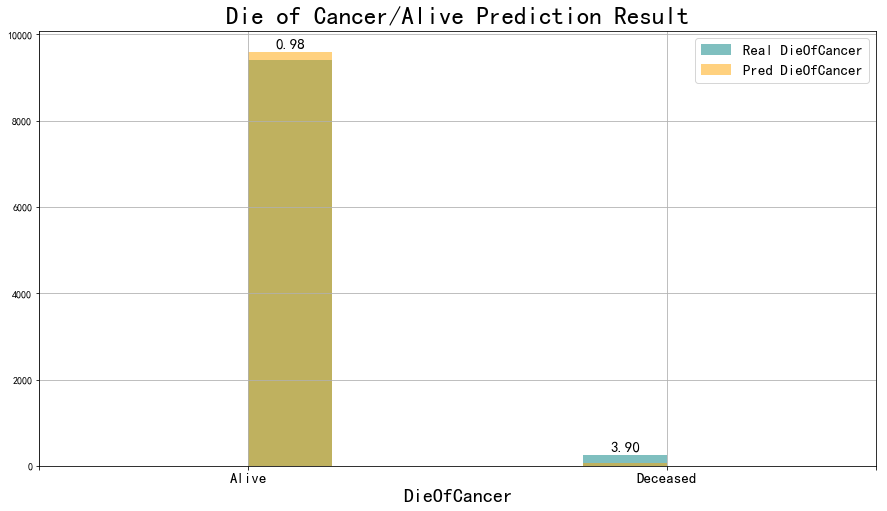

Accuracy Based on Test Data: 0.73
Train/Test split results:
Accuracy: 0.733
Matthews Corr: 0.190


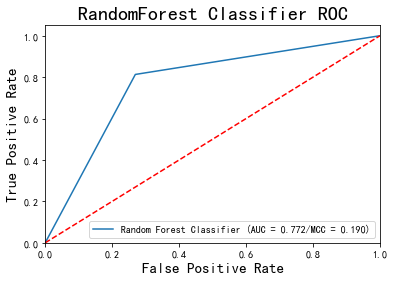

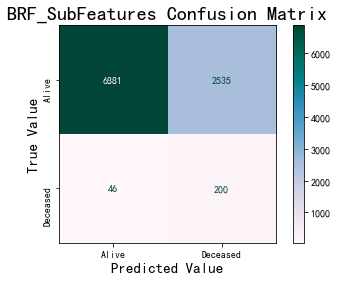

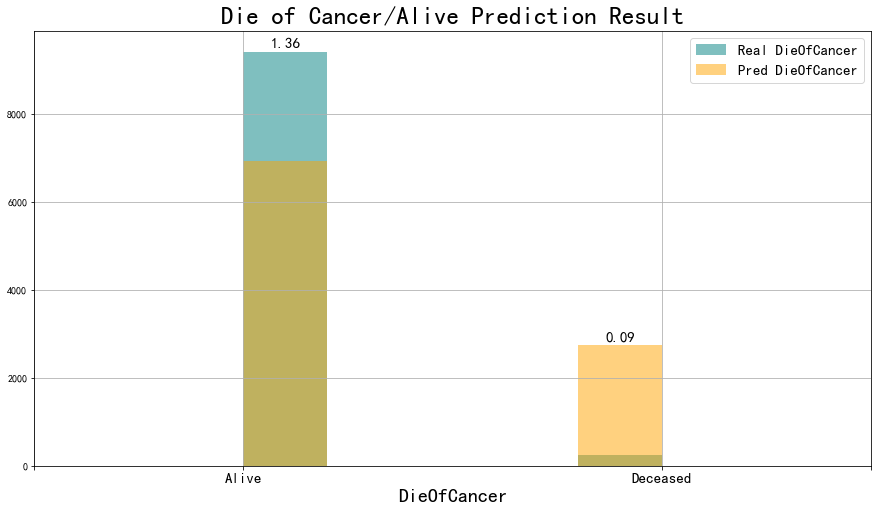

Accuracy Based on Test Data: 0.97
Train/Test split results:
Accuracy: 0.975


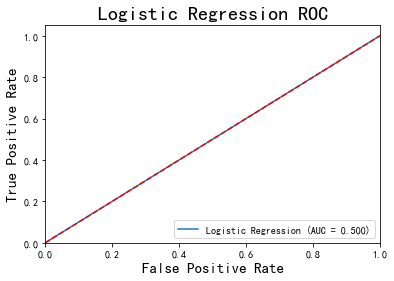

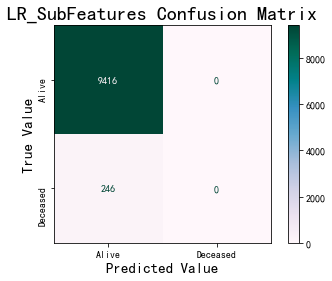

Accuracy Based on Test Data: 0.53
Train/Test split results:
Accuracy: 0.529


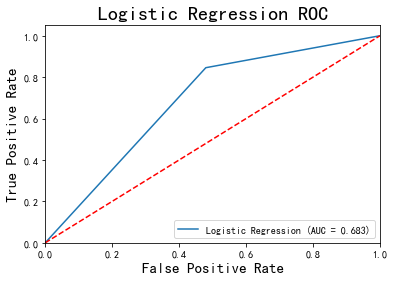

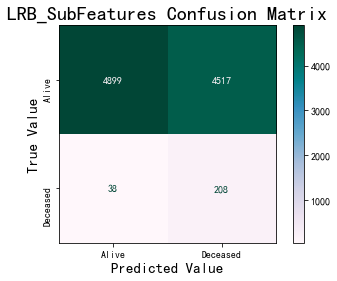

IndexError: list index out of range

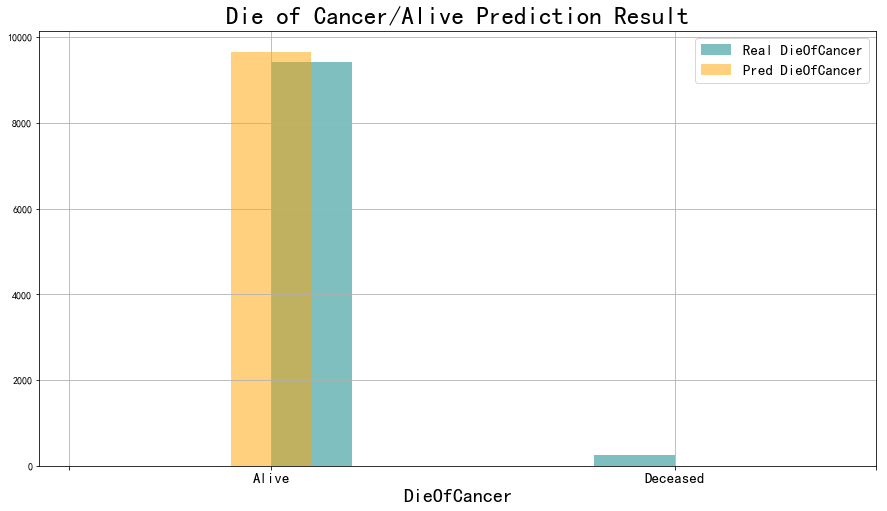

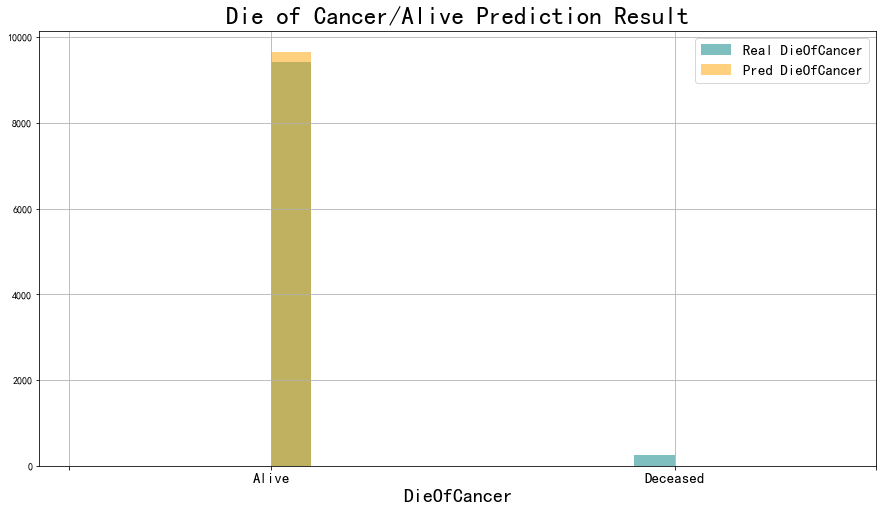

In [139]:
dataDicSub = data_split(raw_df=df, columnList=['Age','Smoking','Alcohol', 'Income'])
# dataDicSub = data_split(raw_df=df, columnList=['Age','Smoking','BMI', 'Weight','Age'])

regressor = RandomForestClassifier(n_estimators=best_estimator, max_features=best_max_features,class_weight={0:alive2cancer,1:1} )
outputDFRF = randomForest_decision(dataDicSub, regressor= regressor, label="RFW_SubFeatures")
draw_Test_Pred(outputDFRF, "RFW_SubFeatures")

regressor = BalancedRandomForestClassifier(class_weight={0:alive2cancer,1:1} )
outputDFBRF = randomForest_decision(dataDicSub, regressor= regressor, label="BRF_SubFeatures")
draw_Test_Pred(outputDFBRF, "BRF_SubFeatures")

outputDFLR = logistic_predict(dataDicSub, label="LR_SubFeatures")
outputDFLRB = logistic_predict(dataDicSub, label="LRB_SubFeatures", is_balance=True)

try:
    draw_Test_Pred(outputDFLR, "LR_SubFeatures")
except IndexError:
    draw_Test_Pred(outputDFLR, "LR_SubFeatures", 10)
    print("An exception occur")
draw_Test_Pred(outputDFLRB, 'LRB_SubFeatures')

### Use all columns of sub dataset (2011-2018) to run regression


Begin to Ingest 2011-2012 data.
Begin to Clean 2011-2012 data.
Total Count of Data: 9756
Age > 18 Count of Data: 5864
Begin to Ingest 2013-2014 data.
Begin to Clean 2013-2014 data.
Total Count of Data: 10175
Age > 18 Count of Data: 6113
Begin to Ingest 2015-2016 data.
Begin to Clean 2015-2016 data.
Total Count of Data: 9971
Age > 18 Count of Data: 5992
Begin to Ingest 2017-2018 data.
Begin to Clean 2017-2018 data.
Total Count of Data: 9254
Age > 18 Count of Data: 5856
Total Population: 20414
Total Cancer Deceased Population: 280 (0.0137 in total)
Total Alive Population: 20134
Train Set cancer deceased population:  217 (0.0142 in total)
Test Set cancer deceased population:  63 (0.0123 in total)
Ratio between Alive and Cancer in train is 70
Accuracy Based on Test Data: 0.99
Train/Test split results:
Accuracy: 0.988
Matthews Corr: 0.000


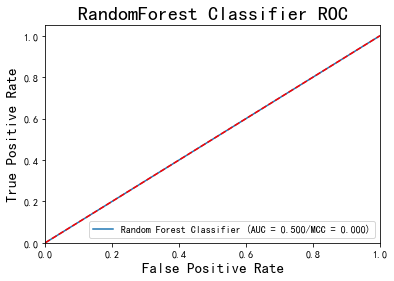

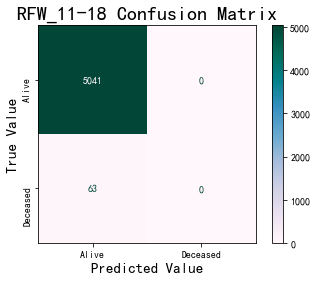

IndexError: list index out of range

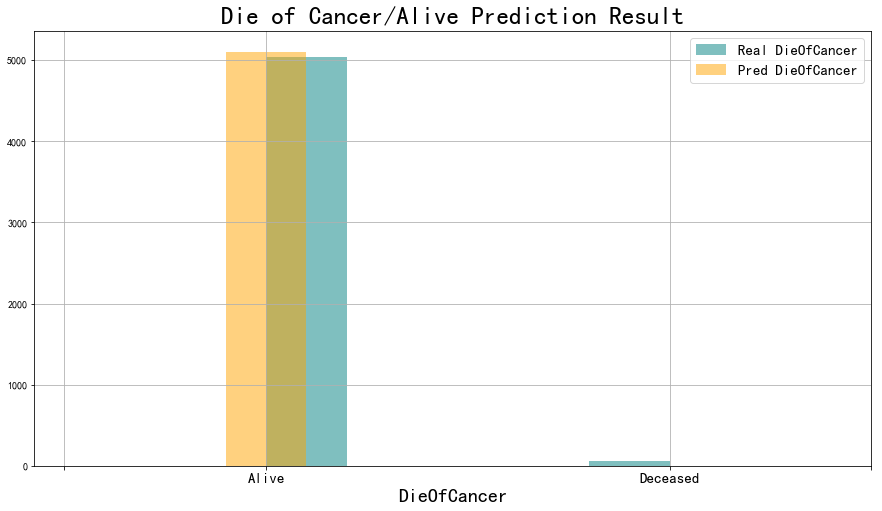

In [146]:
df_sub = dataConcat(2011, 2018)

sub1118DataDicAll = data_split(df_sub)


# ratio between alive records and cancer records
alive2cancer_11_18=cal_aliveCacer_ratio(sub1118DataDicAll)
print("Ratio between Alive and Cancer in train is %d" % alive2cancer_11_18)


regressor = RandomForestClassifier(n_estimators=best_estimator, max_features=best_max_features,class_weight={0:alive2cancer_11_18,1:1} )
outputDFRF = randomForest_decision(sub1118DataDicAll, regressor= regressor, label="RFW_11-18")
draw_Test_Pred(outputDFRF, "RFW_11-18")

regressor = BalancedRandomForestClassifier(class_weight={0:alive2cancer,1:1} )
outputDFBRF = randomForest_decision(sub1118DataDicAll, regressor= regressor, label="BRF_11-18")
draw_Test_Pred(outputDFBRF, "BRF_11-18")

outputDFLR = logistic_predict(sub1118DataDicAll, label="LR_11-18")
outputDFLRB = logistic_predict(sub1118DataDicAll, label="LRB_11-18", is_balance=True)

draw_Test_Pred(outputDFLRB, "LRB_11-18")
try:
    draw_Test_Pred(outputDFLR, "LR_11-18")
except IndexError:
    draw_Test_Pred(outputDFLR, "LR_11-18", 10)
    print("An exception occur")

### Use all columns of sub dataset (2015-2018) to run regression


Begin to Ingest 2015-2016 data.
Begin to Clean 2015-2016 data.
Total Count of Data: 9971
Age > 18 Count of Data: 5992
Begin to Ingest 2017-2018 data.
Begin to Clean 2017-2018 data.
Total Count of Data: 9254
Age > 18 Count of Data: 5856
Total Population: 10302
Total Cancer Deceased Population: 75 (0.0073 in total)
Total Alive Population: 10227
Train Set cancer deceased population:  57 (0.0074 in total)
Test Set cancer deceased population:  18 (0.0070 in total)
Ratio between Alive and Cancer in train is 135
Accuracy Based on Test Data: 0.99
Train/Test split results:
Accuracy: 0.993
Matthews Corr: -0.002


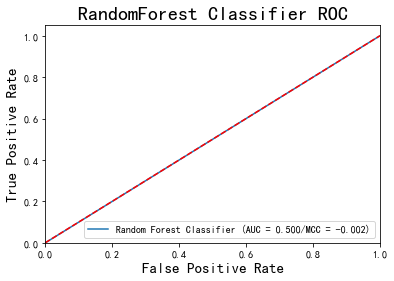

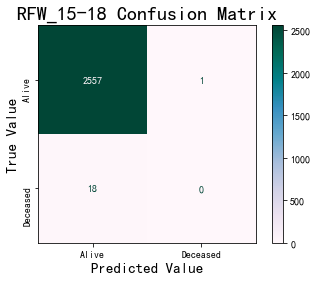

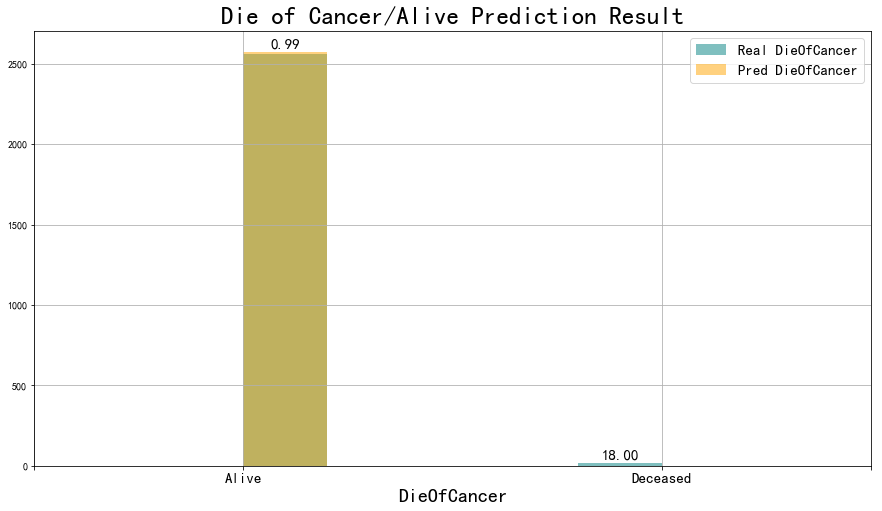

Accuracy Based on Test Data: 0.70
Train/Test split results:
Accuracy: 0.696
Matthews Corr: 0.125


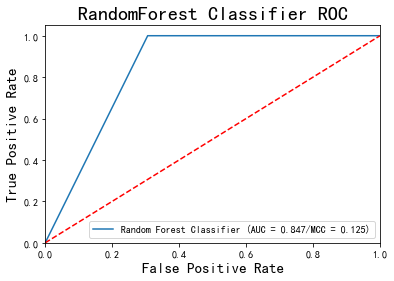

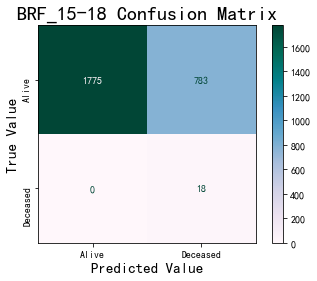

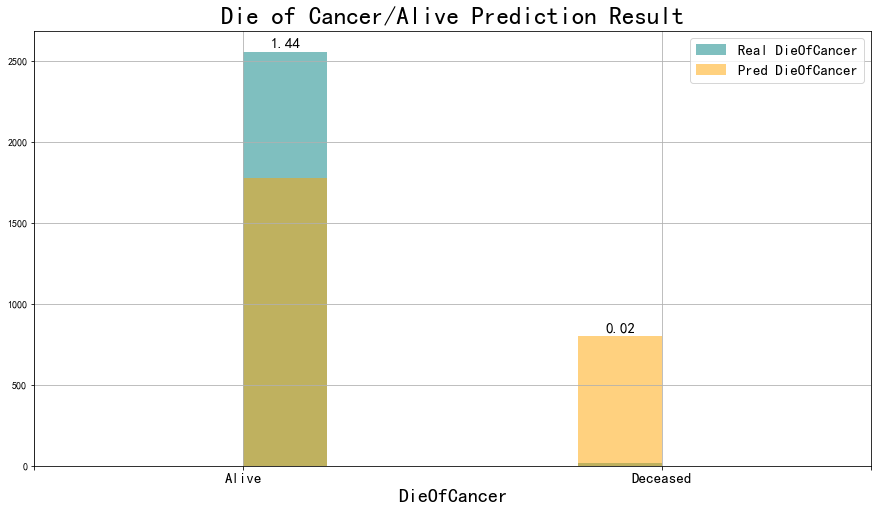

Accuracy Based on Test Data: 0.99
Train/Test split results:
Accuracy: 0.993


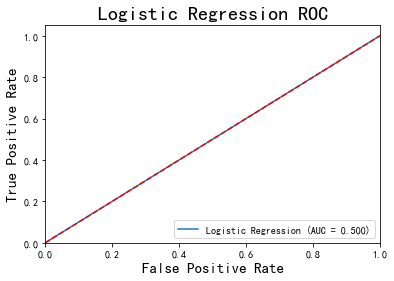

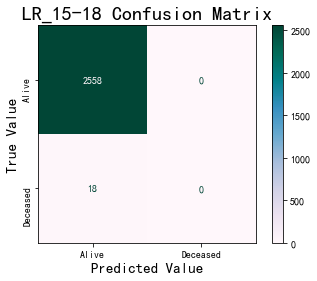

Accuracy Based on Test Data: 0.74
Train/Test split results:
Accuracy: 0.740


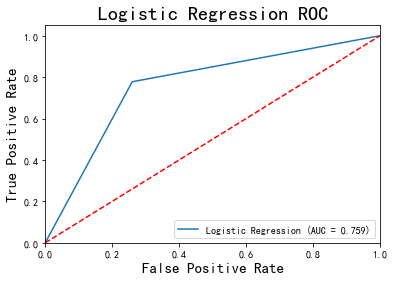

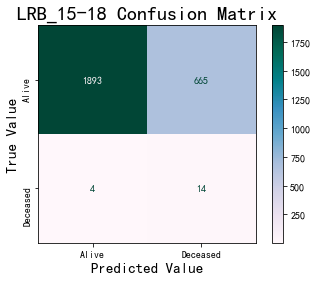

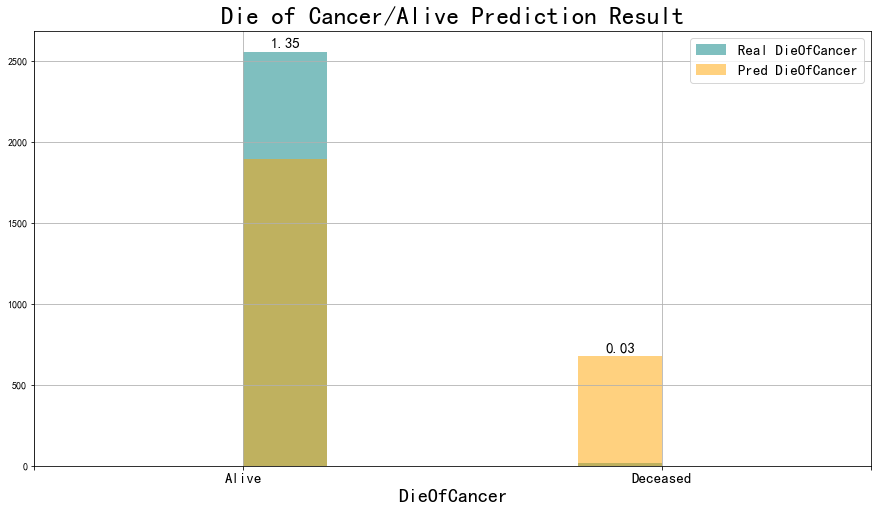

IndexError: list index out of range

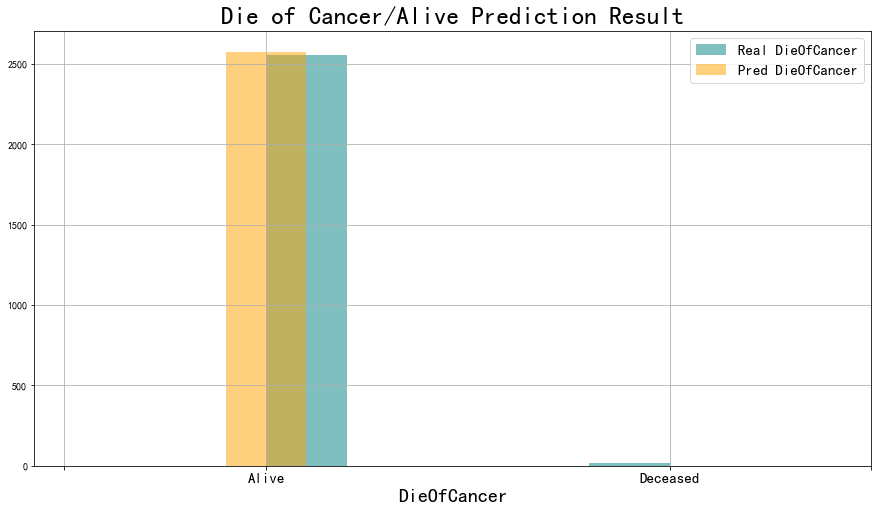

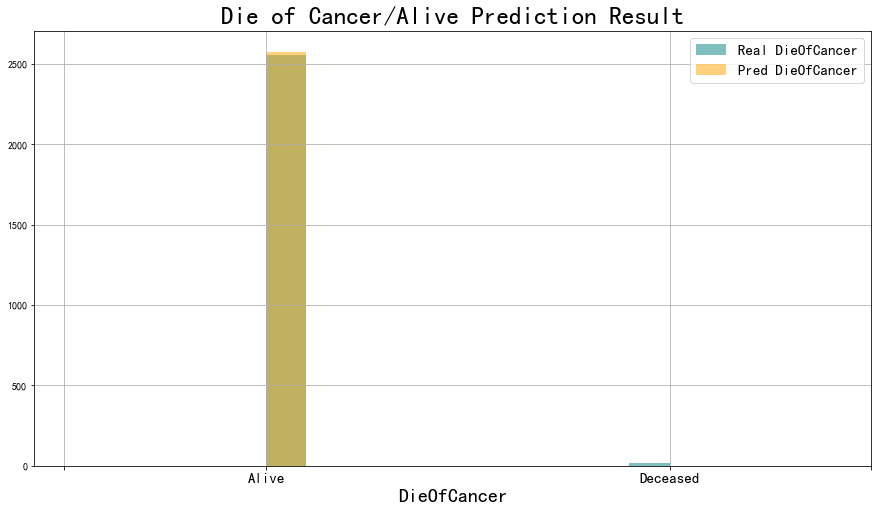

In [147]:
df_sub = dataConcat(2015, 2018)

sub1518DataDicAll = data_split(df_sub)

# ratio between alive records and cancer records
alive2cancer_15_18=cal_aliveCacer_ratio(sub1518DataDicAll)
print("Ratio between Alive and Cancer in train is %d" % alive2cancer_15_18)

regressor = RandomForestClassifier(n_estimators=best_estimator, max_features=best_max_features,class_weight={0:alive2cancer_15_18,1:1} )
outputDFRF = randomForest_decision(sub1518DataDicAll, regressor= regressor, label="RFW_15-18")
draw_Test_Pred(outputDFRF, "RFW_15-18")

regressor = BalancedRandomForestClassifier(class_weight={0:alive2cancer,1:1} )
outputDFBRF = randomForest_decision(sub1518DataDicAll, regressor= regressor, label="BRF_15-18")
draw_Test_Pred(outputDFBRF, "BRF_15-18")

outputDFLR = logistic_predict(sub1518DataDicAll, label="LR_15-18")
outputDFLRB = logistic_predict(sub1518DataDicAll, label="LRB_15-18", is_balance=True)

draw_Test_Pred(outputDFLRB, "LRB_15-18")
try:
    draw_Test_Pred(outputDFLR, "LR_15-18")
except IndexError:
    draw_Test_Pred(outputDFLR, "LR_15-18", 10)
    print("An exception occur")


### Change Split test data ratio from 0.3 to 0.1

Test Data Ratio in total is: 0.300
Total Population: 34971
Total Cancer Deceased Population: 860 (0.0246 in total)
Total Alive Population: 34111
Train Set cancer deceased population:  603 (0.0246 in total)
Test Set cancer deceased population:  257 (0.0245 in total)
Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976
Matthews Corr: 0.109


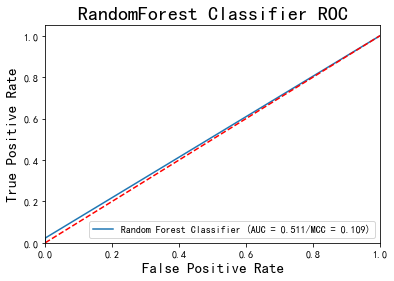

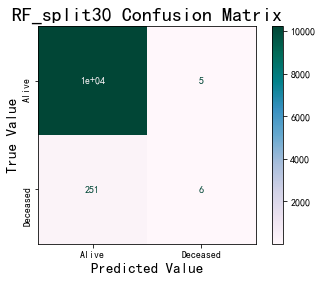

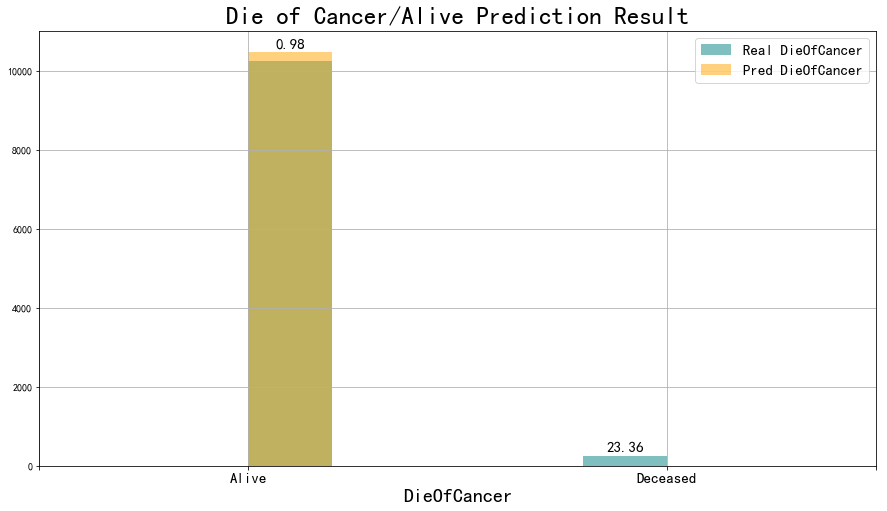

Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976


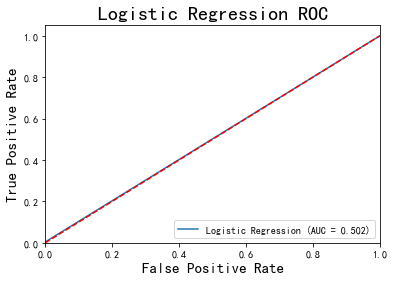

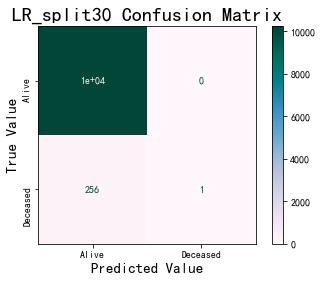

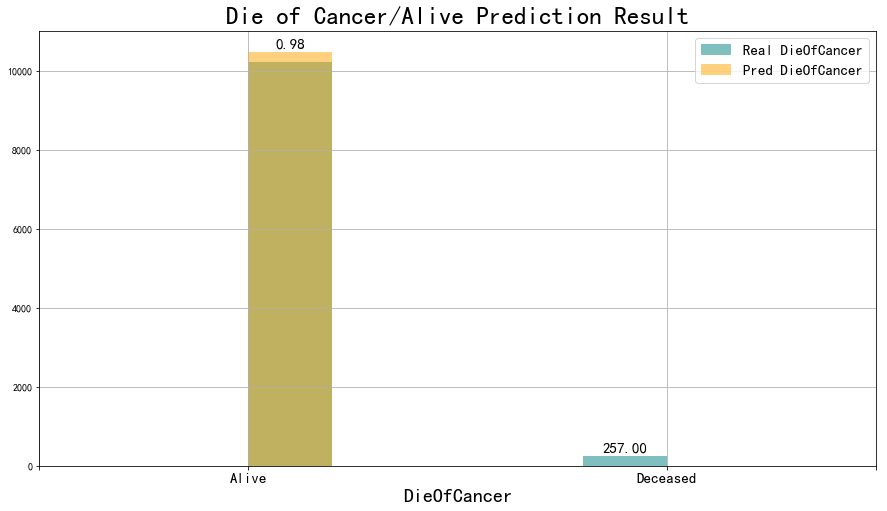

Test Data Ratio in total is: 0.250
Total Population: 34971
Total Cancer Deceased Population: 860 (0.0246 in total)
Total Alive Population: 34111
Train Set cancer deceased population:  644 (0.0246 in total)
Test Set cancer deceased population:  216 (0.0247 in total)
Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.975
Matthews Corr: 0.119


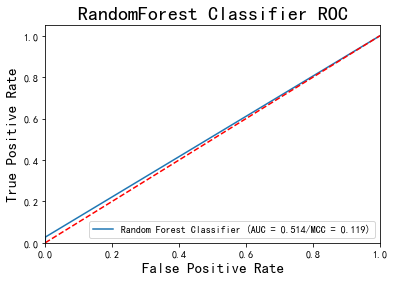

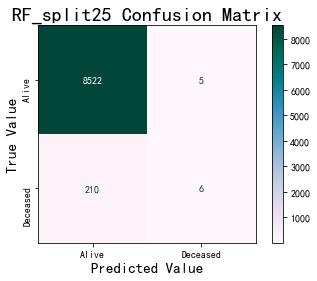

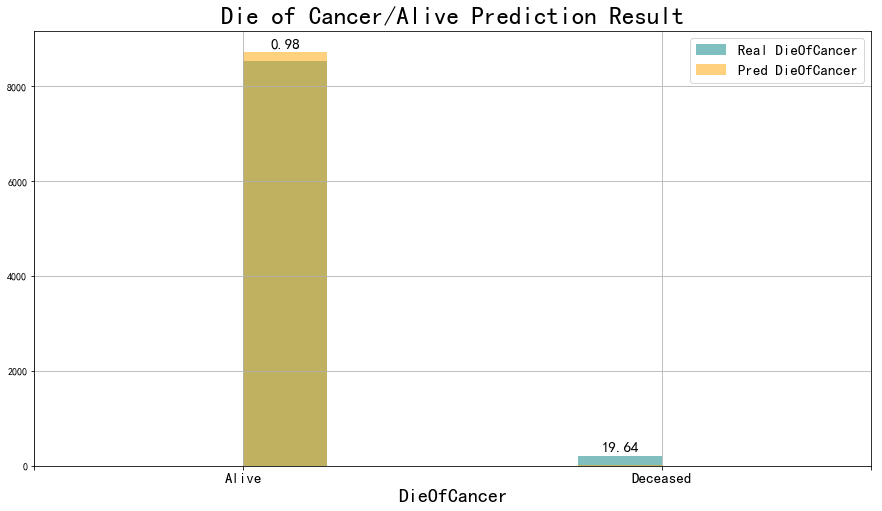

Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976


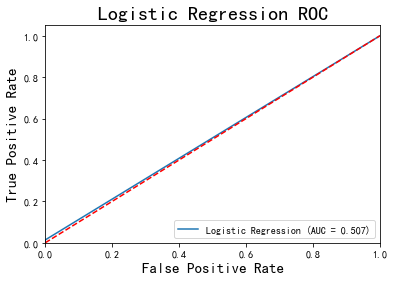

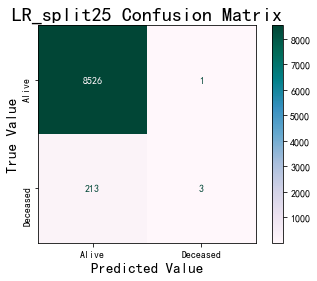

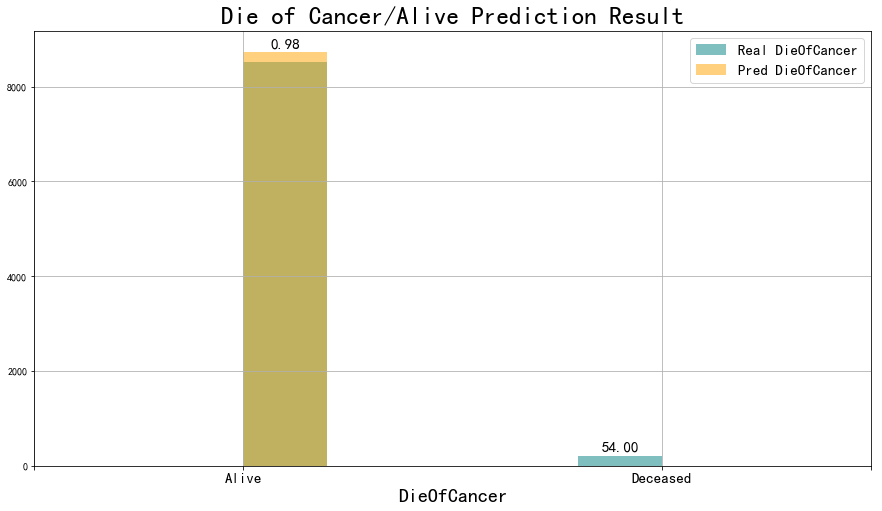

Test Data Ratio in total is: 0.200
Total Population: 34971
Total Cancer Deceased Population: 860 (0.0246 in total)
Total Alive Population: 34111
Train Set cancer deceased population:  690 (0.0247 in total)
Test Set cancer deceased population:  170 (0.0243 in total)
Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976
Matthews Corr: 0.105


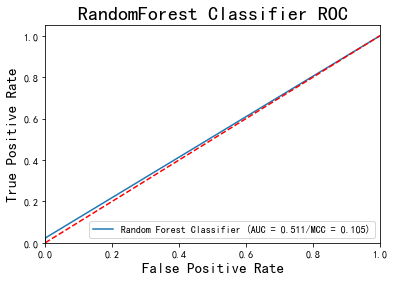

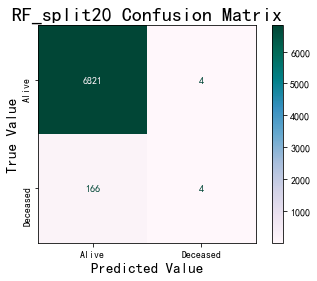

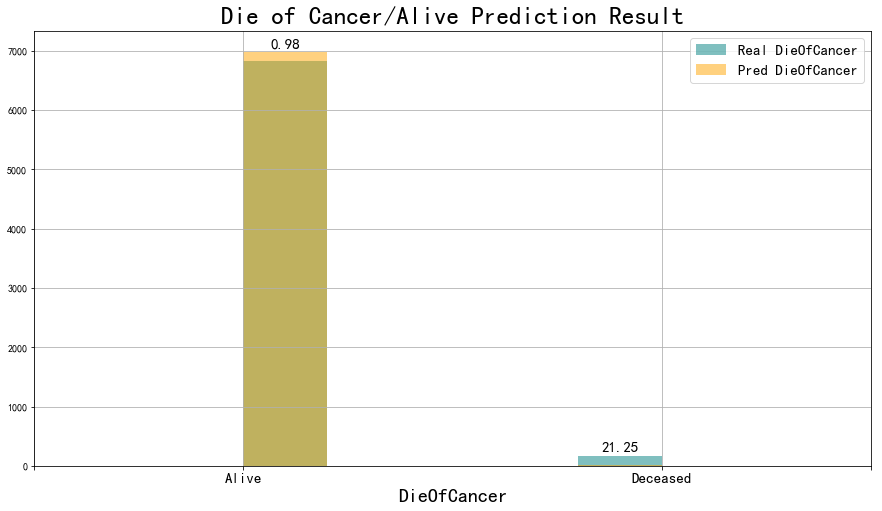

Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976


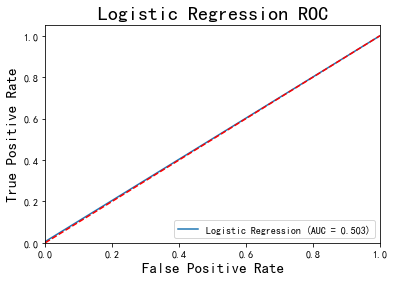

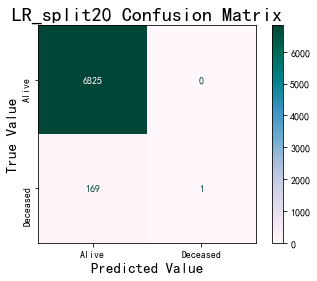

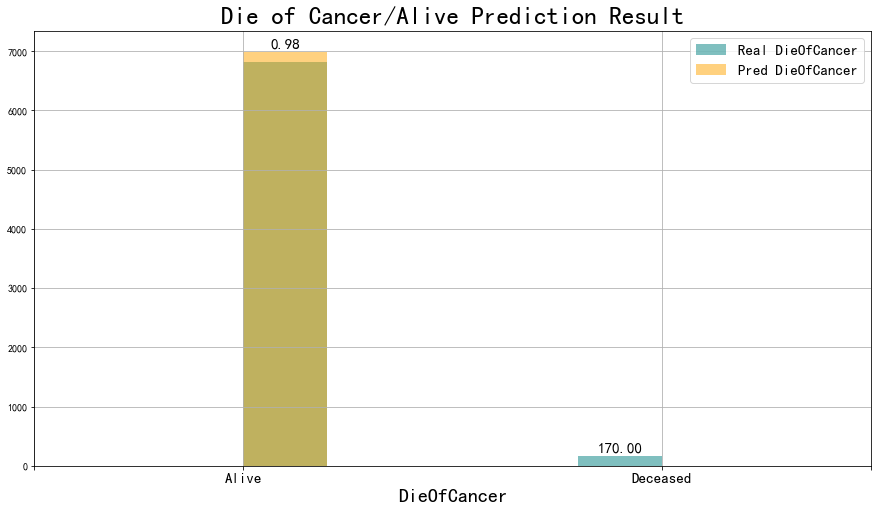

Test Data Ratio in total is: 0.150
Total Population: 34971
Total Cancer Deceased Population: 860 (0.0246 in total)
Total Alive Population: 34111
Train Set cancer deceased population:  733 (0.0247 in total)
Test Set cancer deceased population:  127 (0.0242 in total)
Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976
Matthews Corr: 0.105


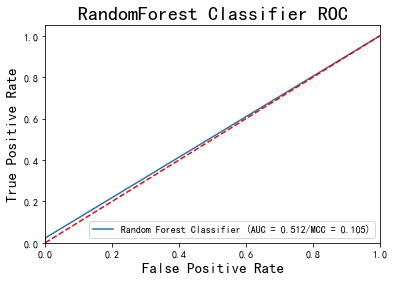

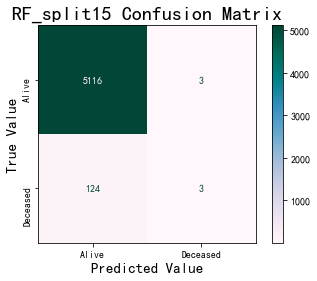

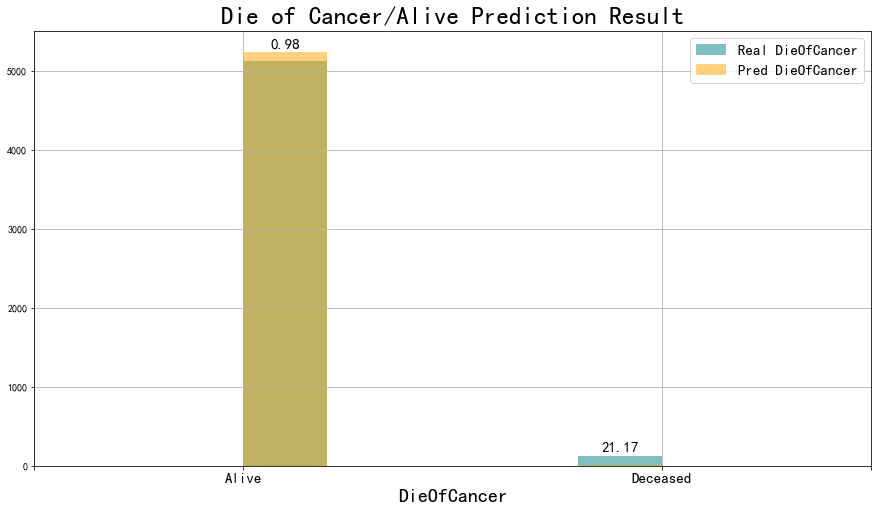

Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976


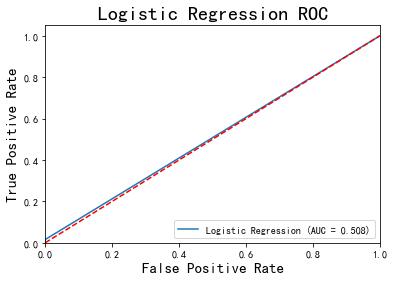

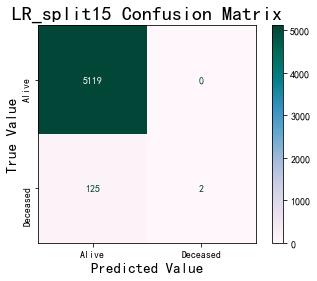

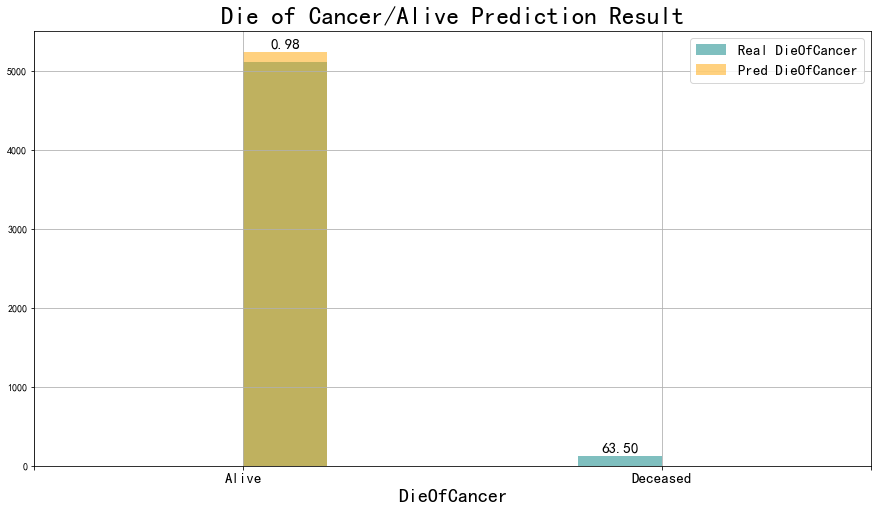

Test Data Ratio in total is: 0.100
Total Population: 34971
Total Cancer Deceased Population: 860 (0.0246 in total)
Total Alive Population: 34111
Train Set cancer deceased population:  761 (0.0242 in total)
Test Set cancer deceased population:  99 (0.0283 in total)
Accuracy Based on Test Data: 0.97
Train/Test split results:
Accuracy: 0.972
Matthews Corr: 0.130


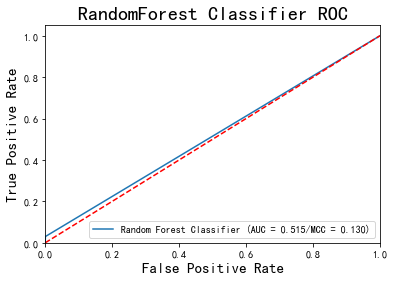

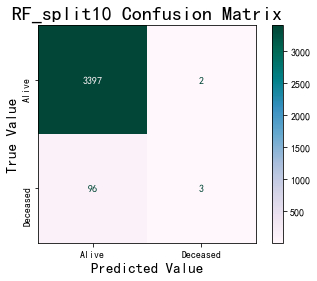

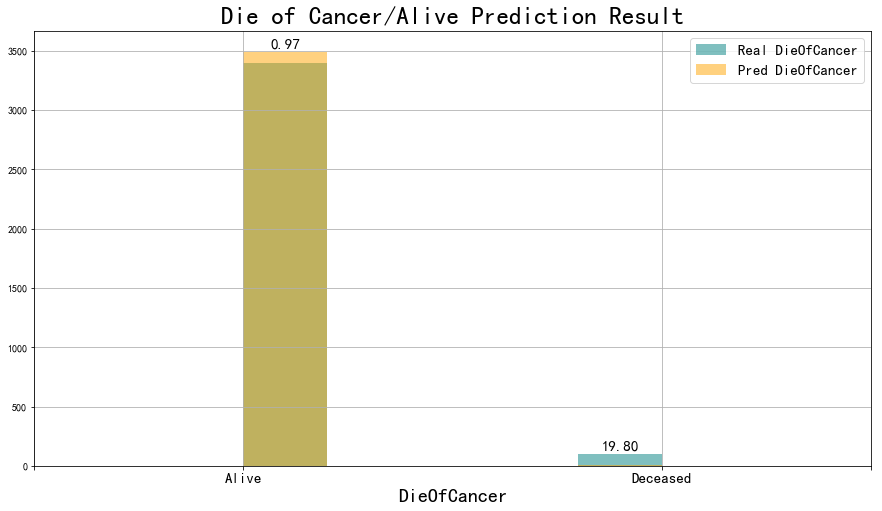

Accuracy Based on Test Data: 0.97
Train/Test split results:
Accuracy: 0.972


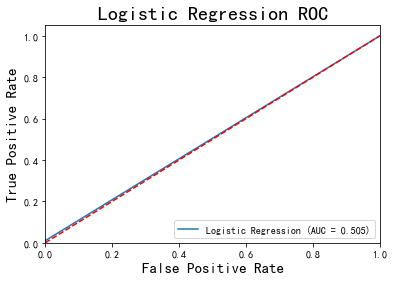

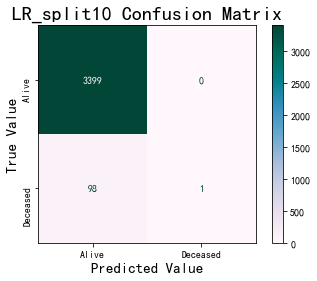

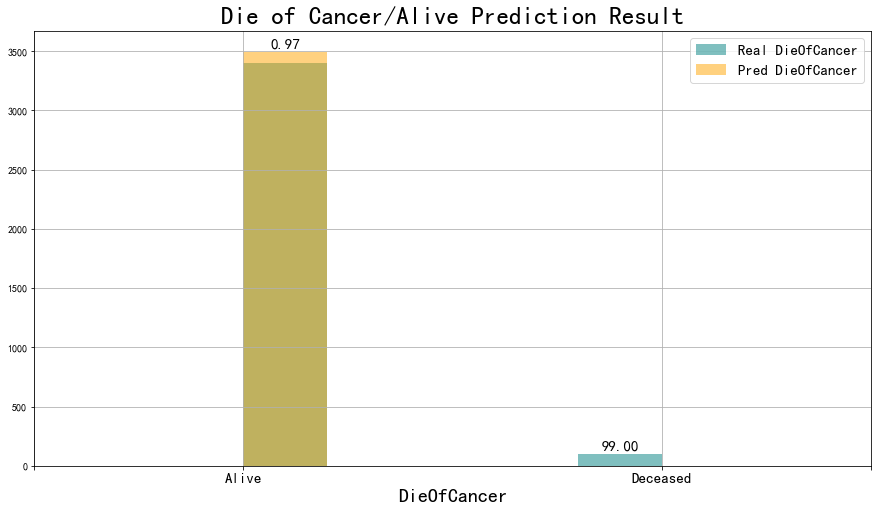

In [81]:
for ratio in [0.3, 0.25, 0.2, 0.15, 0.1]:
    rfLabel = "RF_split%d" % (ratio*100)
    lrLabel = "LR_split%d" % (ratio*100)
    print("Test Data Ratio in total is: %2.3f" % ratio)
    dataDicSplitTest = data_split(raw_df=df, ratio=ratio)

    regressor = RandomForestClassifier(class_weight={0:alive2cancer,1:1} )
    outputDFRFBal = randomForest_decision(dataDicSplitTest, regressor= regressor, label=rfLabel)
    draw_Test_Pred(outputDFRFBal, rfLabel)


    outputDFLR = logistic_predict(dataDicSplitTest, label=lrLabel)

    try:
        draw_Test_Pred(outputDFLR, lrLabel)
    except IndexError:
        draw_Test_Pred(outputDFLR, lrLabel, 10)
        print("An exception occur")

### Split data into train 0.75 vs test 0.25

Total Population: 34971
Total Cancer Deceased Population: 860 (0.0246 in total)
Total Alive Population: 34111
Train Set cancer deceased population:  644 (0.0246 in total)
Test Set cancer deceased population:  216 (0.0247 in total)
Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.975
Matthews Corr: 0.114


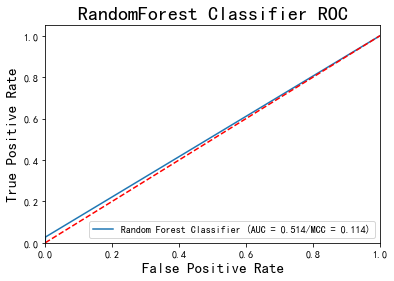

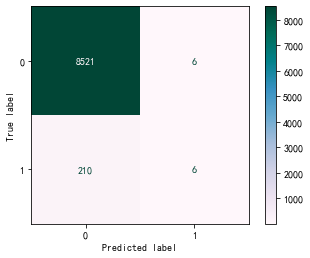

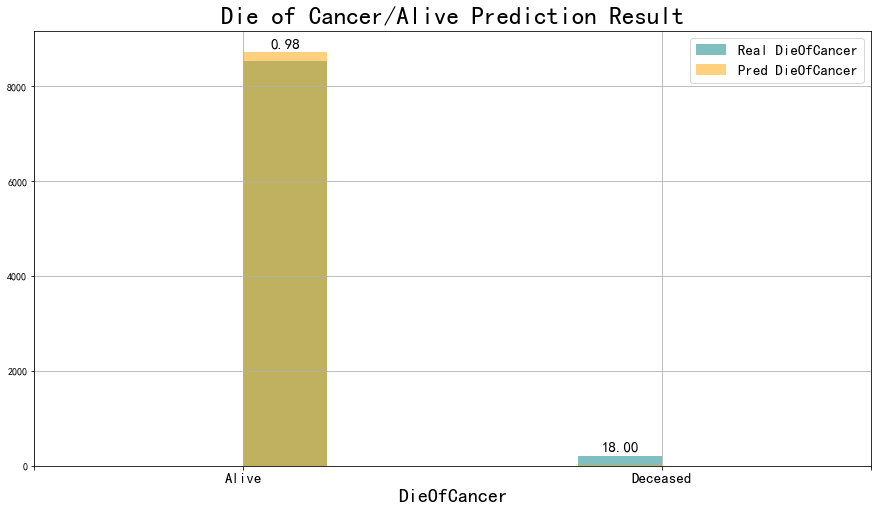

Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976


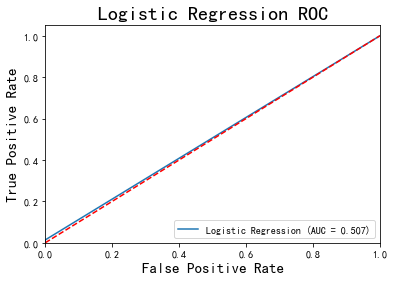

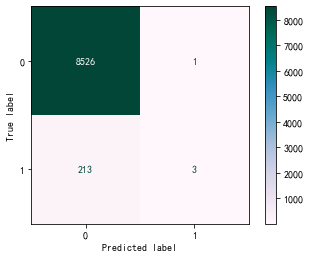

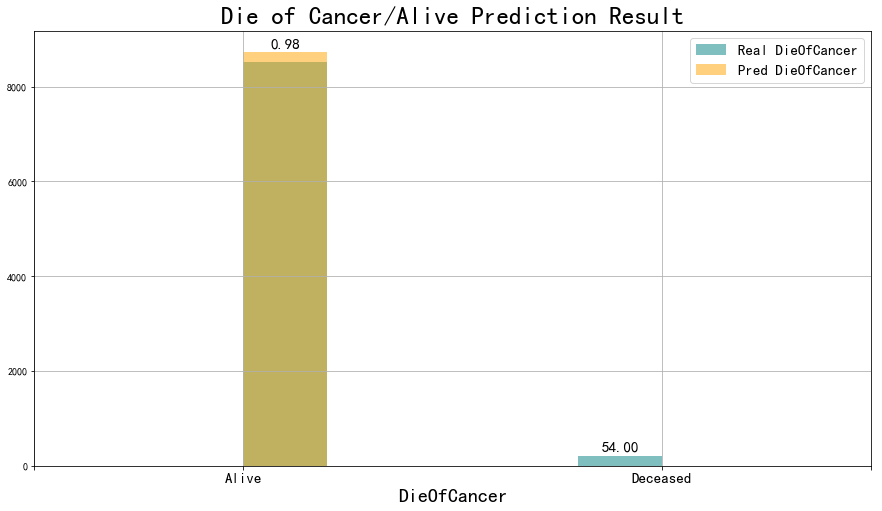

In [29]:
dataDicAll30 = data_split(raw_df=df, ratio=0.25)

regressor = RandomForestClassifier(class_weight={0:alive2cancer,1:1} )
outputDFRFBal = randomForest_decision(dataDicAll30, regressor= regressor, label="RF_split25")
draw_Test_Pred(outputDFRFBal, "RF_split25")


outputDFLR = logistic_predict(dataDicAll30, label="LR_split25")

try:
    draw_Test_Pred(outputDFLR, "LR_split25")
except IndexError:
    draw_Test_Pred(outputDFLR, "LR_split25", 10)
    print("An exception occur")



### Split data into train 0.8 vs test 0.2

Total Population: 34971
Total Cancer Deceased Population: 860 (0.0246 in total)
Total Alive Population: 34111
Train Set cancer deceased population:  690 (0.0247 in total)
Test Set cancer deceased population:  170 (0.0243 in total)
Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976
Matthews Corr: 0.098


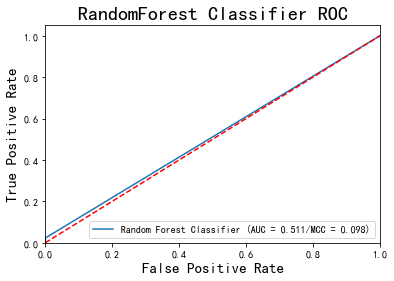

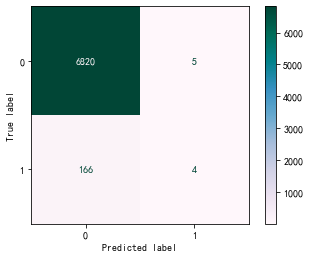

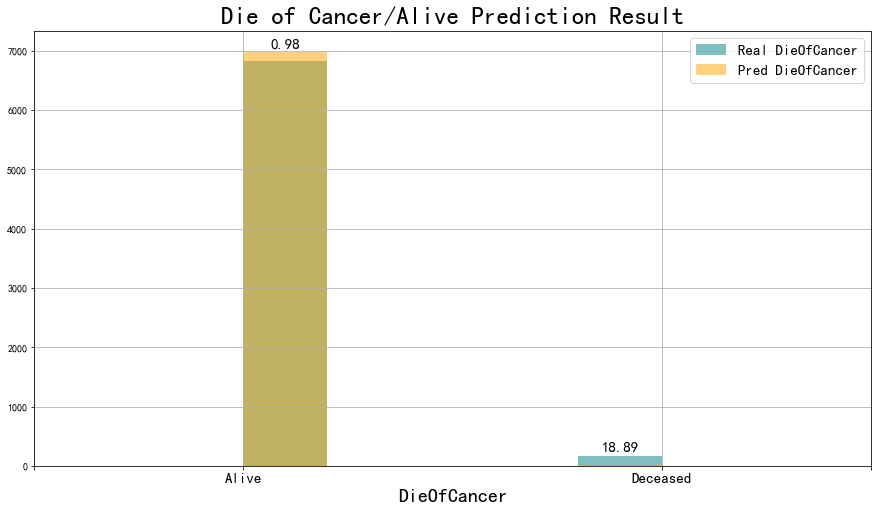

Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976


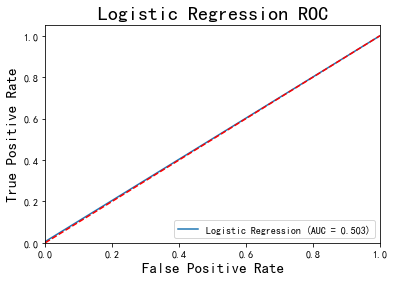

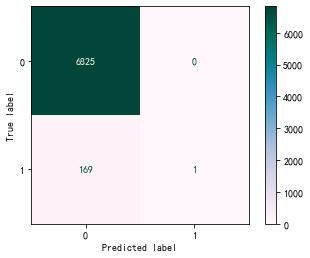

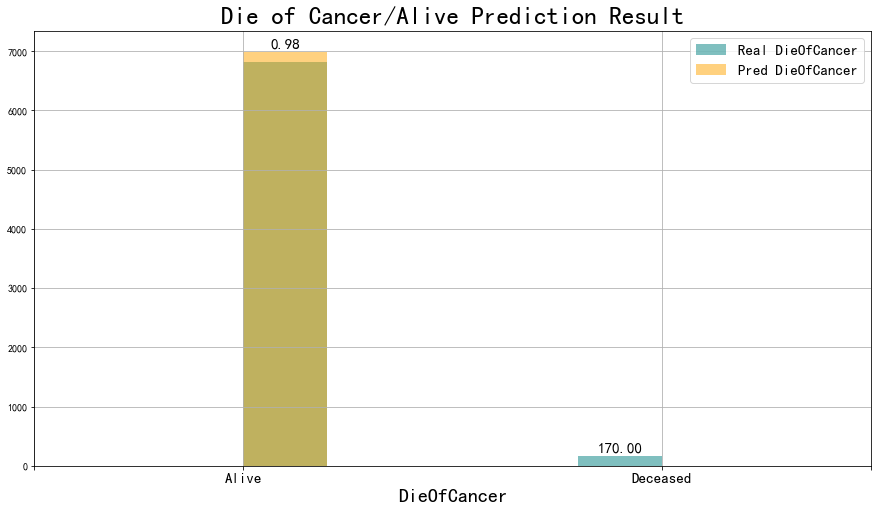

In [26]:
dataDicAll20 = data_split(raw_df=df, ratio=0.2)

regressor = RandomForestClassifier(class_weight={0:alive2cancer,1:1} )
outputDFRFBal = randomForest_decision(dataDicAll20, regressor= regressor, label="RF_split20")
draw_Test_Pred(outputDFRFBal, "RF_split20")


outputDFLR = logistic_predict(dataDicAll20, label="LR_split20")

try:
    draw_Test_Pred(outputDFLR, "LR_split20")
except IndexError:
    draw_Test_Pred(outputDFLR, "LR_split20", 10)
    print("An exception occur")

### Split data into train 0.85 vs test 0.15

Total Population: 34971
Total Cancer Deceased Population: 860 (0.0246 in total)
Total Alive Population: 34111
Train Set cancer deceased population:  733 (0.0247 in total)
Test Set cancer deceased population:  127 (0.0242 in total)
Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976
Matthews Corr: 0.105


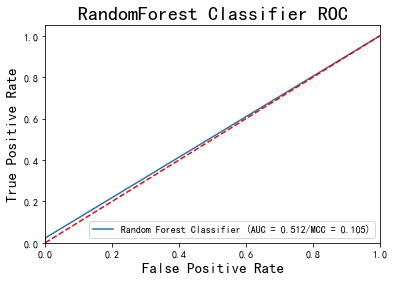

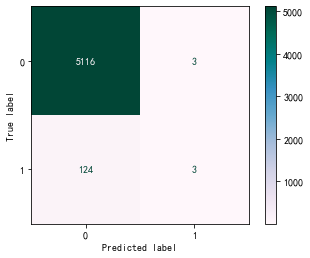

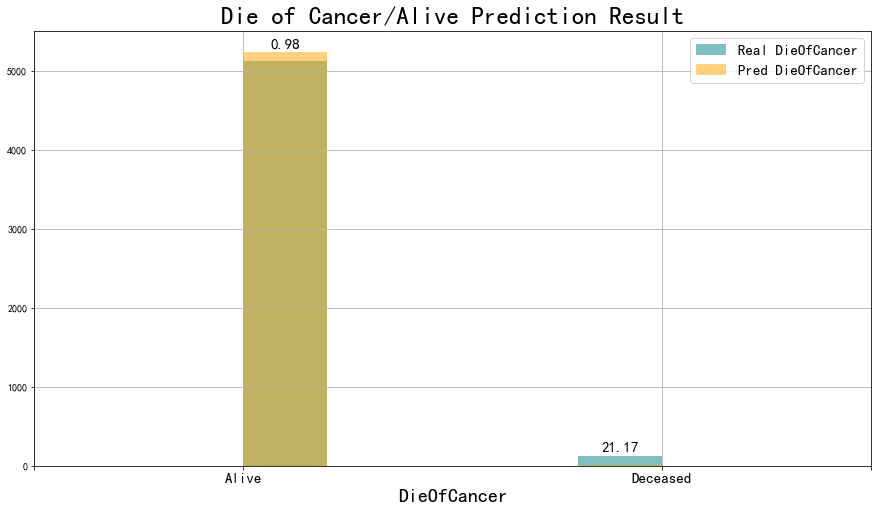

Accuracy Based on Test Data: 0.98
Train/Test split results:
Accuracy: 0.976


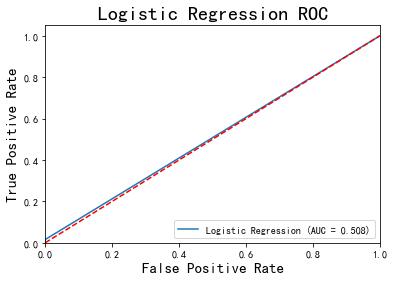

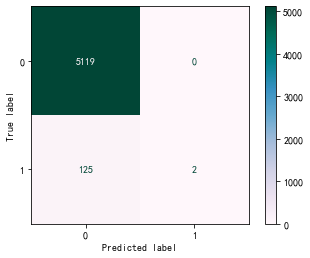

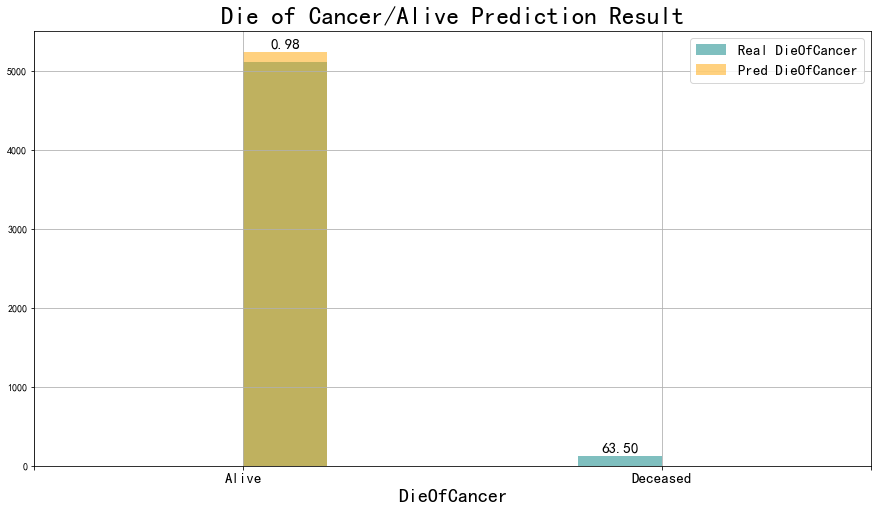

In [27]:
dataDicAll15 = data_split(raw_df=df, ratio=0.15)

regressor = RandomForestClassifier(class_weight={0:alive2cancer,1:1} )
outputDFRFBal = randomForest_decision(dataDicAll15, regressor= regressor, label="RF_split15")
draw_Test_Pred(outputDFRFBal, "RF_split15")


outputDFLR = logistic_predict(dataDicAll15, label="LR_split15")

try:
    draw_Test_Pred(outputDFLR, "LR_split15")
except IndexError:
    draw_Test_Pred(outputDFLR, "LR_split15", 10)
    print("An exception occur")

### Split data into train 0.9 vs test 0.1

Total Population: 34971
Total Cancer Deceased Population: 860 (0.0246 in total)
Total Alive Population: 34111
Train Set cancer deceased population:  761 (0.0242 in total)
Test Set cancer deceased population:  99 (0.0283 in total)
Accuracy Based on Test Data: 0.97
Train/Test split results:
Accuracy: 0.972
Matthews Corr: 0.130


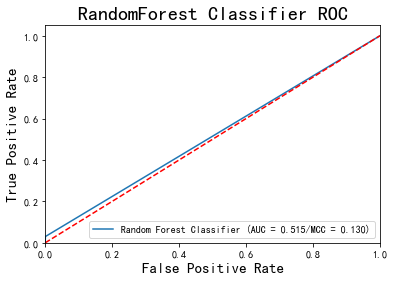

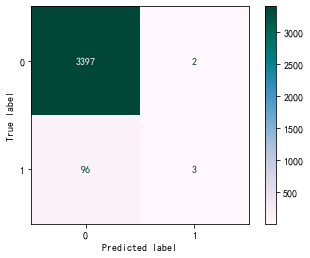

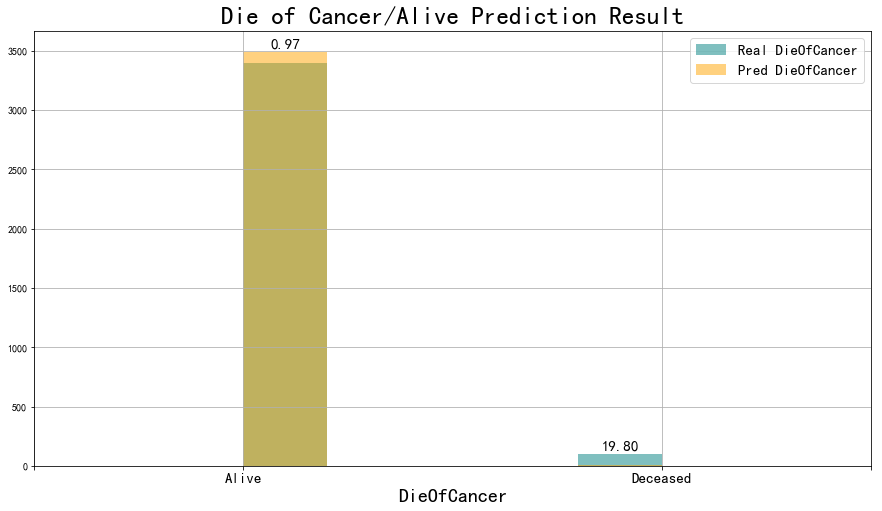

Accuracy Based on Test Data: 0.97
Train/Test split results:
Accuracy: 0.972


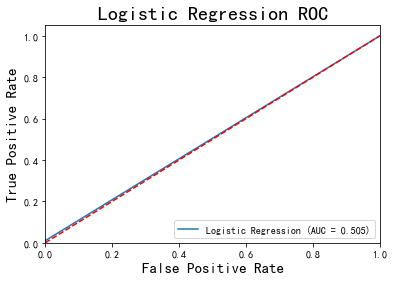

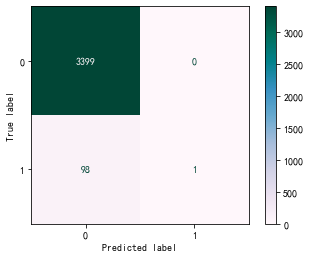

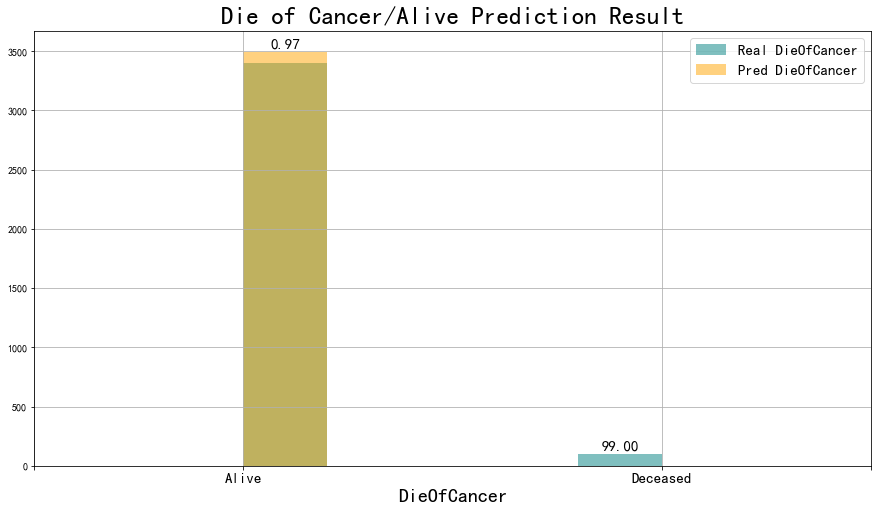

In [30]:
dataDicAll10 = data_split(raw_df=df, ratio=0.1)

regressor = RandomForestClassifier(class_weight={0:alive2cancer,1:1} )
outputDFRFBal = randomForest_decision(dataDicAll10, regressor= regressor, label="RF_split10")
draw_Test_Pred(outputDFRFBal, "RF_split10")


outputDFLR = logistic_predict(dataDicAll10, label="LR_split10")

try:
    draw_Test_Pred(outputDFLR, "LR_split10")
except IndexError:
    draw_Test_Pred(outputDFLR, "LR_split10", 10)
    print("An exception occur")


### To do logistic Regression on Male

In [ ]:
# Use following Character to predict
VN =[VNH[x] for x in ['Age','Smoking','HDLC',]]
VNA = VN + [VNH['DieOfCancer'],]
maleIndex=df.loc[:,VNH['Gender']]==1

X_Y=df.loc[maleIndex,VNA]

# print("Record Count without NaN: %d"%X_Y.shape[0])
# print("Die of Cancer with NaN: %d"%X_Y[X_Y['dieOfCancer']==0].shape[0])
X_Y.dropna(inplace=True)
# print("Record Count without NaN: %d"%X_Y.shape[0])
# print("Die of Cancer without NaN: %d"%X_Y[X_Y['dieOfCancer']==0].shape[0])

outputDF = logistic_predict(X_Y)

draw_Test_Pred(outputDF)

outputDF.to_csv("Test&Pred_male.csv")

### To do logistic Regression on Female


In [ ]:
# Use following Character to predict
VN =[VNH[x] for x in ['Age','Income',]]
VNA = VN + [VNH['DieOfCancer'],]
femaleIndex=df.loc[:,VNH['Gender']]==2
X_Y=df.loc[femaleIndex,VNA]

# print("Record Count without NaN: %d"%X_Y.shape[0])
# print("Die of Cancer with NaN: %d"%X_Y[X_Y['dieOfCancer']==0].shape[0])
X_Y.dropna(inplace=True)
# print("Record Count without NaN: %d"%X_Y.shape[0])
# print("Die of Cancer without NaN: %d"%X_Y[X_Y['dieOfCancer']==0].shape[0])


outputDF = logistic_predict(X_Y)

draw_Test_Pred(outputDF)

outputDF.to_csv("Test&Pred_female.csv")